In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import random
import re

# Comparison on multiple datasets

In [24]:
import openml
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

In [25]:
import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

In [26]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [27]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [28]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [29]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [30]:
shap.initjs()

In [31]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [32]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [33]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [34]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            if len((set(v1)|set(v2))) == 0:
                jackard = 0
            else:
                jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [35]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        accuracy =  accuracy_score(dataset['class'],np.ones(len(dataset))*float(prediction))
        precision =  precision_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        recall =  recall_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        f1 =  f1_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        return 1,accuracy, precision, recall, f1
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [36]:
def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            if len(set(rule_1.keys())|set(rule_2.keys())) == 0:
                feature_jackart[i,ii] = 0
            else:
                feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired



In [37]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

## Benchmark, model agnostic

In [38]:
def predict_lux(model,X,y=None):
        if isinstance(X, pd.DataFrame):
            pass
        elif isinstance(X,np.ndarray):
            X = pd.DataFrame(X,columns=model.attributes_names)
        else:
            raise ValueError("Only 2D arrrays are allowed as an input")
            
        if y is None:
            y = pd.Series(np.arange(X.shape[0]),name='target_unused',index=X.index) # This is not used, but Data resered last 
                
        X=pd.concat((X,y),axis=1)
        XData = Data.parse_dataframe(X,'lux')
        return [int(f.get_name()) for f in model.predict(XData.get_instances())]

In [39]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [40]:
suite = openml.study.get_suite(99)
print(suite)
tasks = suite.tasks
skip=True
num=0
dds=['kr-vs-kp', 'letter', 'balance-scale', 'mfeat-factors', 'mfeat-fourier', 'breast-w', 'mfeat-karhunen', 'mfeat-morphological', 
     'mfeat-zernike', 'cmc', 'optdigits', 'credit-approval', 'credit-g', 'pendigits', 'diabetes', 'spambase', 'splice', 'tic-tac-toe', 
     'vehicle', 'electricity', 'satimage', 'eucalyptus', 'sick', 'vowel', 'isolet', 'analcatdata_authorship', 'analcatdata_dmft',
     'mnist_784', 'pc4', 'pc3', 'jm1', 'kc2', 'kc1', 'pc1', 'adult', 'Bioresponse', 'wdbc', 'phoneme', 'qsar-biodeg', 'wall-robot-navigation',
     'semeion', 'ilpd', 'madelon', 'nomao', 'ozone-level-8hr', 'cnae-9', 'first-order-theorem-proving', 'banknote-authentication', 
     'blood-transfusion-service-center', 'PhishingWebsites', 'cylinder-bands', 'bank-marketing', 'GesturePhaseSegmentationProcessed', 'har', 
     'dresses-sales', 'texture', 'connect-4', 'MiceProtein', 'steel-plates-fault', 'climate-model-simulation-crashes', 'wilt', 'car', 'segment', 
     'mfeat-pixel', 'Fashion-MNIST', 'jungle_chess_2pcs_raw_endgame_complete', 'numerai28.6', 'Devnagari-Script', 'CIFAR_10', 'Internet-Advertisements', 
     'dna', 'churn']

use_suite = True

if not use_suite:
    all_datasets = openml.datasets.list_datasets(output_format='dataframe')
    classification_datasets = all_datasets[(all_datasets['NumberOfClasses']>1) & (all_datasets['NumberOfInstances']>1000) & (all_datasets['NumberOfInstances']< 2000)& (all_datasets['NumberOfFeatures'] <= 20) &(all_datasets['NumberOfMissingValues']==0)].drop_duplicates(subset=['name'])
    classification_datasets['name']= classification_datasets['name'].apply(lambda x: x.split('_')[0])
    classification_datasets=classification_datasets.drop_duplicates(subset=['name'])
    classification_datasets[~classification_datasets['name'].isin(dds)]
    tasks = classification_datasets['did']

OpenML Benchmark Suite
ID..............: 99
Name............: OpenML-CC18 Curated Classification benchmark
Status..........: active
Main Entity Type: task
Study URL.......: https://www.openml.org/s/99
# of Data.......: 72
# of Tasks......: 72
Creator.........: https://www.openml.org/u/1
Upload Time.....: 2019-02-21 18:47:13


In [41]:
import os

def save_append(df, filepath):
    # Check if file exists
    file_exists = os.path.isfile(filepath)
    df.to_csv(filepath, mode='a', header=not file_exists, index=False)

Processing ilpd
ilpd
Accuracy  model: 0.6438356164383562 for ilpd
Train size: 437
----------- Model certainty for instance: 0.6 ---------------
Neighbourhood size: 14
Average distace of neighbourhood: 1.0099928161098906.
Neighbourhood size: 14
Average distace of neighbourhood: 0.899302499041353.
Train sample size: 43 (0.09839816933638444)


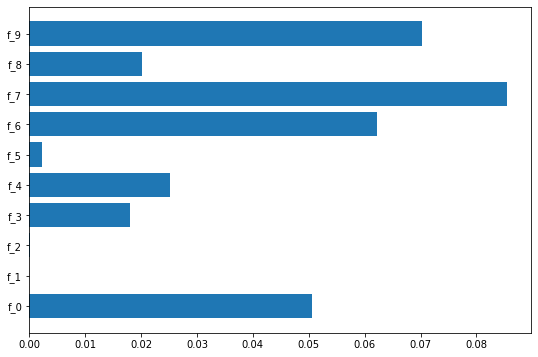

Fidelity  dectree: 0.9090909090909091
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.16279069767441862
--- 0.1808490753173828 seconds ---
IF f_5 >=-0.308080792427063 THEN class = 0 # 1.0



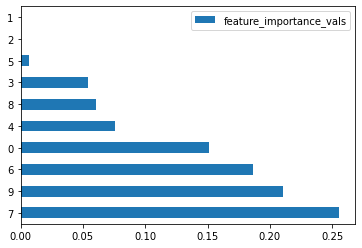

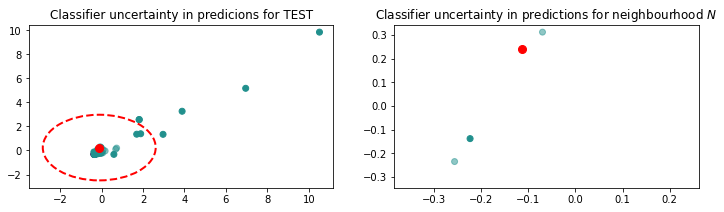

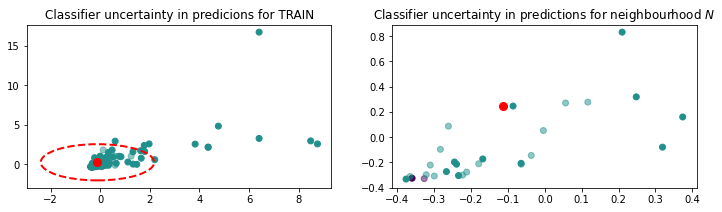

Fidelity  with ablation: 0.8333333333333333
f_5>=-0.308080792427063
f_5>=-0.308080792427063
SHAP Ablation coverage: nn: 0.7857142857142857 and local: 0.684931506849315
Full rule: {'rule': {'f_5': ['>= -0.308080792427063']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.006627480586712641


Exact explainer: 134it [00:27,  3.04it/s]                         


Done 0.7969924812030075 upsampling
Done 0.9849624060150376 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 370 (0.8466819221967964)
Lux w shap
In fact using: 0.8466819221967964 samples from train set wiuth class balance: 0.20540540540540542


Exact explainer: 312it [00:59,  4.54it/s]                         
Exact explainer: 291it [00:55,  4.44it/s]                         
Exact explainer: 281it [00:53,  4.41it/s]                         
Exact explainer: 224it [00:38,  4.71it/s]                         
Exact explainer: 207it [00:33,  4.89it/s]                         


--- 300.92828249931335 seconds ---
IF f_0 <0.5020214915275574 AND f_0 >=-0.5007142126560211 AND f_7 >=-0.013118254952132702 THEN class = 0 # 0.9820627802690582



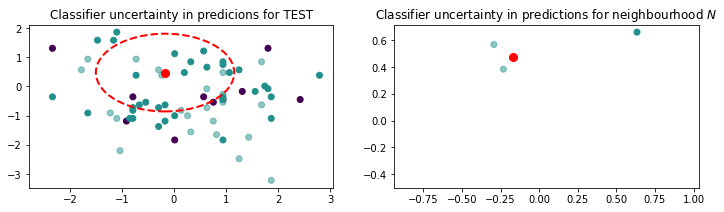

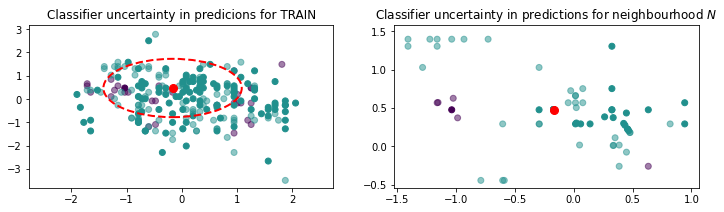

Fidelity  with shap: 0.8571428571428572
f_0<0.5020214915275574 and f_0>=-0.5007142126560211 and f_7>=-0.013118254952132702
f_0<0.5020214915275574 and f_0>=-0.5007142126560211 and f_7>=-0.013118254952132702
SHAP coverage: nn: 0.42857142857142855 and local: 0.17123287671232876
Full rule: {'rule': {'f_0': ['>= -0.8167246878147125', '< 0.5020214915275574', '>= -0.5007142126560211'], 'f_7': ['>= -0.013118254952132702']}, 'prediction': '0', 'confidence': 0.9820627802690582}
SHAPGAIN LUX:0.20345933994823184
Fidelity  EXPLAN: 0.761904761904762
LORE expl e = {'f_0': ['>=-0.36052267253398895'], 'f_9': ['<-0.3806324750185013'], 'f_6': ['>=-0.18848749995231628'], 'f_7': ['>=-0.2313898652791977']}
f_0>=-0.36052267253398895 and f_9<-0.3806324750185013 and f_6>=-0.18848749995231628 and f_7>=-0.2313898652791977
f_0>=-0.36052267253398895 and f_9<-0.3806324750185013 and f_6>=-0.18848749995231628 and f_7>=-0.2313898652791977
Explan coverage: nn: 0.14285714285714285 and local: 0.07534246575342465
Full rul

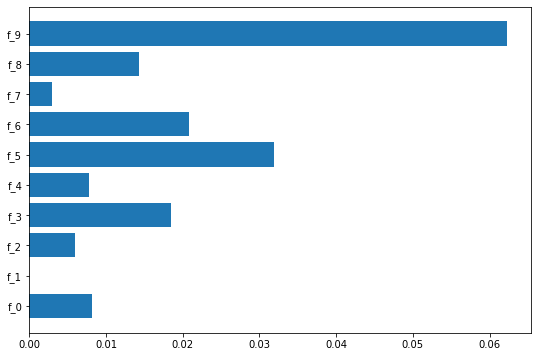

Fidelity  dectree: 0.8000000000000002
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.3023255813953488
--- 0.08961105346679688 seconds ---
IF f_0 <0.8811764419078827 AND f_6 >=-0.30973294377326965 AND f_9 <0.637725368142128 THEN class = 0 # 1.0



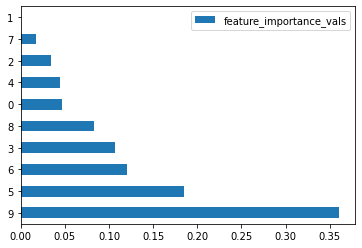

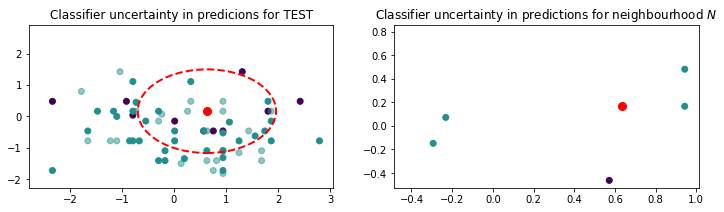

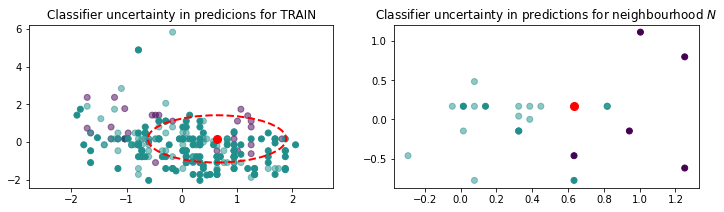

Fidelity  with ablation: 0.8421052631578948
f_0<0.8811764419078827 and f_6>=-0.30973294377326965 and f_9<0.637725368142128
f_0<0.8811764419078827 and f_6>=-0.30973294377326965 and f_9<0.637725368142128
SHAP Ablation coverage: nn: 0.42857142857142855 and local: 0.4452054794520548
Full rule: {'rule': {'f_0': ['< 0.8811764419078827'], 'f_6': ['>= -0.30973294377326965'], 'f_9': ['< 0.637725368142128']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.1761415453589804


Exact explainer: 112it [00:21,  2.72it/s]                         


Done 0.7027027027027027 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 300 (0.6864988558352403)
Lux w shap
In fact using: 0.6864988558352403 samples from train set wiuth class balance: 0.22666666666666666


Exact explainer: 124it [00:24,  3.02it/s]                         
Exact explainer: 178it [00:24,  5.09it/s]                         
Exact explainer: 174it [00:23,  5.16it/s]                         


--- 131.14680004119873 seconds ---
IF f_6 >=-0.24190103262662888 AND f_9 <0.766281932592392 THEN class = 0 # 0.9942196531791907



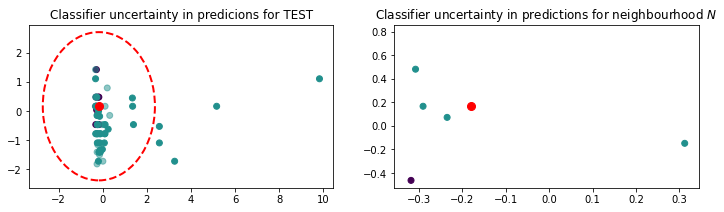

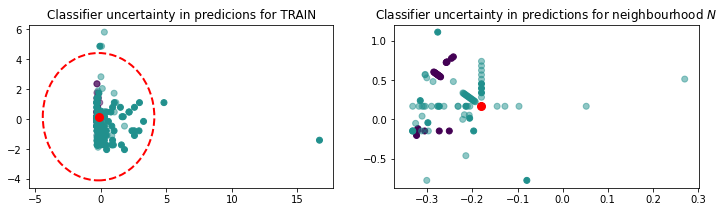

Fidelity  with shap: 0.8000000000000002
f_6>=-0.24190103262662888 and f_9<0.766281932592392
f_6>=-0.24190103262662888 and f_9<0.766281932592392
SHAP coverage: nn: 0.5 and local: 0.410958904109589
Full rule: {'rule': {'f_6': ['>= -0.24190103262662888'], 'f_9': ['< 0.766281932592392']}, 'prediction': '0', 'confidence': 0.9942196531791907}
SHAPGAIN LUX:0.240674797936551
Fidelity  EXPLAN: 0.9090909090909091
LORE expl e = {'f_0': ['>=-0.32431747019290924'], 'f_7': ['>=0.05917333625257015'], 'f_8': ['>=0.04999397788196802']}
f_0>=-0.32431747019290924 and f_7>=0.05917333625257015 and f_8>=0.04999397788196802
f_0>=-0.32431747019290924 and f_7>=0.05917333625257015 and f_8>=0.04999397788196802
Explan coverage: nn: 0.5 and local: 0.2054794520547945
Full rule: {'rule': {'f_0': ['>= -0.32431747019290924'], 'f_7': ['>= 0.05917333625257015'], 'f_8': ['>= -1.1849642395973206', '>= 0.04999397788196802']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN explan:0.04904172149008318
Fidelity  LORE: 0.869565

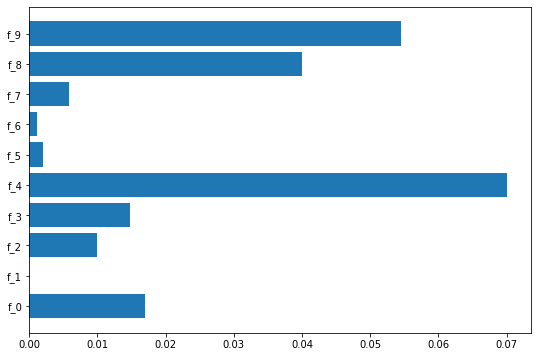

Fidelity  dectree: 0.8181818181818182
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.13953488372093023
--- 0.06650352478027344 seconds ---
IF f_4 >=-0.3834569454193115 THEN class = 0 # 1.0



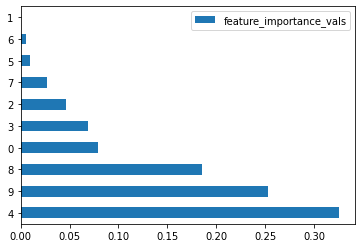

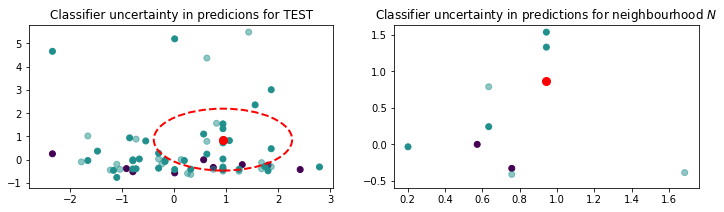

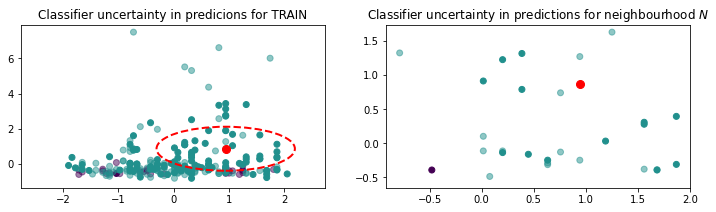

Fidelity  with ablation: 0.88
f_4>=-0.3834569454193115
f_4>=-0.3834569454193115
SHAP Ablation coverage: nn: 0.7142857142857143 and local: 0.6164383561643836
Full rule: {'rule': {'f_4': ['>= -0.3834569454193115']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.3257084443550691


Exact explainer: 146it [00:25,  3.44it/s]                         


Done 0.7862068965517242 upsampling
Done 0.9724137931034482 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 400 (0.9153318077803204)
Lux w shap
In fact using: 0.9153318077803204 samples from train set wiuth class balance: 0.175


Exact explainer: 91it [00:13,  1.83it/s]                        
Exact explainer: 311it [00:56,  4.64it/s]                         
Exact explainer: 307it [00:54,  4.78it/s]                         
Exact explainer: 305it [00:48,  5.24it/s]                         


--- 227.4351568222046 seconds ---
IF f_4 >=-0.38981054723262787 AND f_8 <-0.36718563735485077 THEN class = 0 # 0.9967320261437909



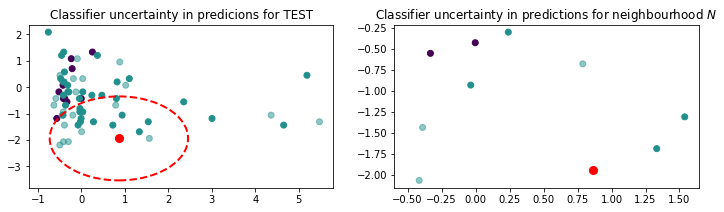

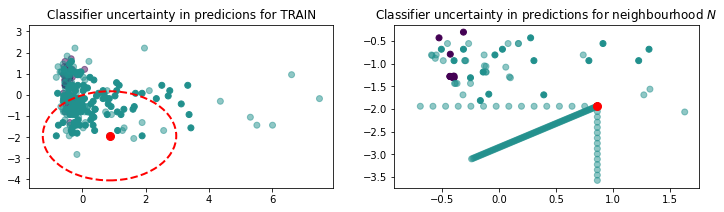

Fidelity  with shap: 0.8181818181818182
f_4>=-0.38981054723262787 and f_8<-0.36718563735485077
f_4>=-0.38981054723262787 and f_8<-0.36718563735485077
SHAP coverage: nn: 0.7142857142857143 and local: 0.2671232876712329
Full rule: {'rule': {'f_4': ['>= -0.38981054723262787'], 'f_8': ['< -0.36718563735485077']}, 'prediction': '0', 'confidence': 0.9967320261437909}
SHAPGAIN LUX:0.25571866673369914
Fidelity  EXPLAN: 0.9166666666666666
LORE expl e = {'f_2': ['<1.0618937611579895'], 'f_0': ['>=-0.032115270383656025'], 'f_9': ['<-0.47372719645500183'], 'f_8': ['<-0.49299775063991547']}
f_2<1.0618937611579895 and f_0>=-0.032115270383656025 and f_9<-0.47372719645500183 and f_8<-0.49299775063991547
f_2<1.0618937611579895 and f_0>=-0.032115270383656025 and f_9<-0.47372719645500183 and f_8<-0.49299775063991547
Explan coverage: nn: 0.5714285714285714 and local: 0.0958904109589041
Full rule: {'rule': {'f_2': ['< 1.0618937611579895'], 'f_0': ['>= -0.032115270383656025'], 'f_9': ['< -0.4737271964550018

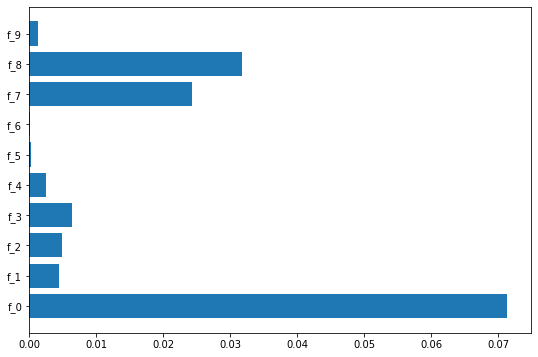

Fidelity  dectree: 0.7826086956521738
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.06976744186046512
--- 0.06786870956420898 seconds ---
IF f_6 >=-0.282019704580307 THEN class = 0 # 1.0



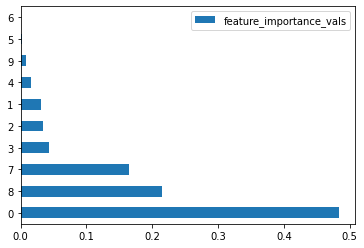

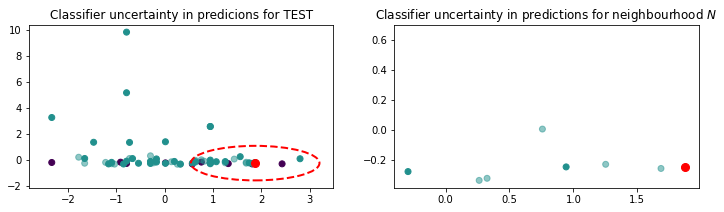

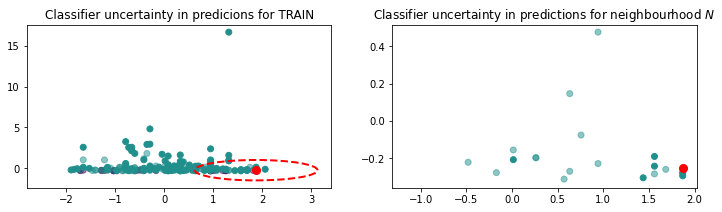

Fidelity  with ablation: 0.962962962962963
f_6>=-0.282019704580307
f_6>=-0.282019704580307
SHAP Ablation coverage: nn: 0.6428571428571429 and local: 0.6438356164383562
Full rule: {'rule': {'f_6': ['>= -0.282019704580307']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.0005874146413098774


Exact explainer: 146it [00:51,  2.26it/s]                         


Done 0.6620689655172414 upsampling
Done 0.9724137931034482 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 382 (0.8741418764302059)
Lux w shap
In fact using: 0.8741418764302059 samples from train set wiuth class balance: 0.17539267015706805


Exact explainer: 145it [00:51,  2.26it/s]                         
Exact explainer: 119it [00:21,  2.94it/s]                         
Exact explainer: 100it [00:17,  2.43it/s]                       
Exact explainer: 90it [00:14,  1.84it/s]                        
Exact explainer: 239it [01:02,  3.36it/s]                         
Exact explainer: 229it [00:59,  3.37it/s]                         
Exact explainer: 227it [01:01,  3.22it/s]                         
Exact explainer: 218it [00:55,  3.41it/s]                         
Exact explainer: 215it [00:51,  3.59it/s]                         


--- 468.44264912605286 seconds ---
IF f_0 >=0.21881715208292007 AND f_1 >=-1.5126672387123108 AND f_2 >=-0.26497748494148254 THEN class = 0 # 0.9911504424778761



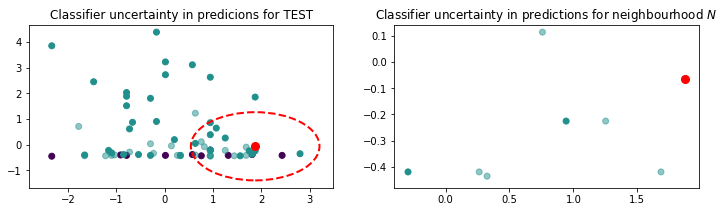

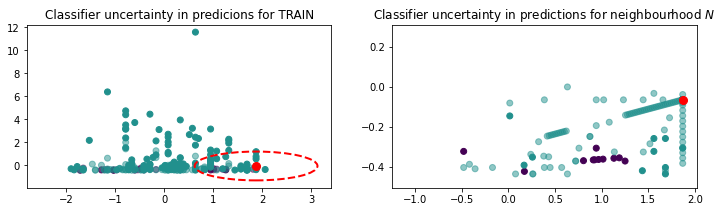

Fidelity  with shap: 0.9230769230769231
f_0>=0.21881715208292007 and f_1>=-1.5126672387123108 and f_2>=-0.26497748494148254
f_0>=0.21881715208292007 and f_1>=-1.5126672387123108 and f_2>=-0.26497748494148254
SHAP coverage: nn: 0.2857142857142857 and local: 0.136986301369863
Full rule: {'rule': {'f_0': ['>= 0.21881715208292007'], 'f_1': ['>= -1.5126672387123108'], 'f_2': ['>= -0.26497748494148254']}, 'prediction': '0', 'confidence': 0.9911504424778761}
SHAPGAIN LUX:0.1827838558876093
Fidelity  EXPLAN: 0.9230769230769231
LORE expl e = {'f_0': ['>=0.9739067554473877'], 'f_1': ['== 0.5674464422768072'], 'f_6': ['>=-0.2976084053516388'], 'f_7': ['<-2.5755187273025513']}
f_0>=0.9739067554473877 and f_1== 0.5674464422768072 and f_6>=-0.2976084053516388 and f_7<-2.5755187273025513
f_0>=0.9739067554473877 and f_1== 0.5674464422768072 and f_6>=-0.2976084053516388 and f_7<-2.5755187273025513
Explan coverage: nn: 0.07142857142857142 and local: 0.00684931506849315
Full rule: {'rule': {'f_0': ['>= 0

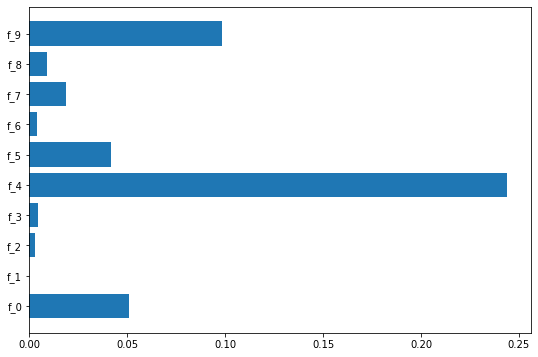

Fidelity  dectree: 0.8000000000000002
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.18604651162790697
--- 0.08250188827514648 seconds ---
IF f_6 >=-0.19887996464967728 AND f_9 <-0.07394890936447496 THEN class = 0 # 1.0



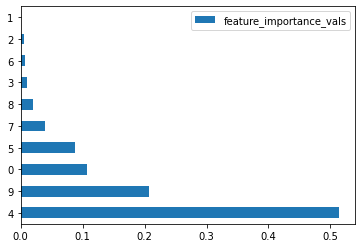

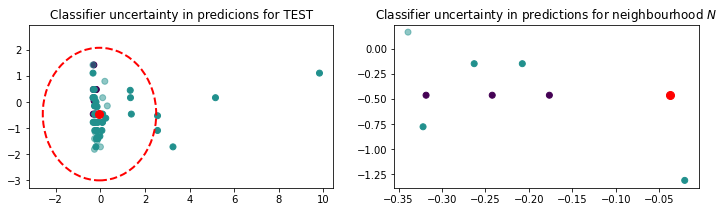

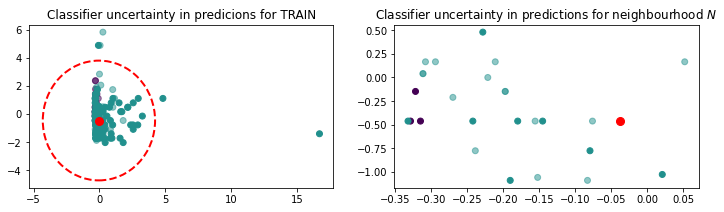

Fidelity  with ablation: 0.7368421052631577
f_6>=-0.19887996464967728 and f_9<-0.07394890936447496
f_6>=-0.19887996464967728 and f_9<-0.07394890936447496
SHAP Ablation coverage: nn: 0.2857142857142857 and local: 0.23972602739726026
Full rule: {'rule': {'f_6': ['>= -0.19887996464967728'], 'f_9': ['< -0.07394890936447496']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.1075615207425822


Exact explainer: 124it [00:22,  3.05it/s]                         


Done 0.8536585365853658 upsampling
Done 0.983739837398374 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 349 (0.7986270022883295)
Lux w shap
In fact using: 0.7986270022883295 samples from train set wiuth class balance: 0.2722063037249284


Exact explainer: 229it [00:46,  3.90it/s]                         
Exact explainer: 91it [00:18,  2.28it/s]                        
Exact explainer: 139it [00:25,  3.35it/s]                         
Exact explainer: 106it [00:18,  2.70it/s]                         
Exact explainer: 96it [00:16,  2.36it/s]                        
Exact explainer: 92it [00:14,  2.09it/s]                        


--- 200.30794167518616 seconds ---
IF f_4 >=0.7084940969944 THEN class = 0 # 1.0



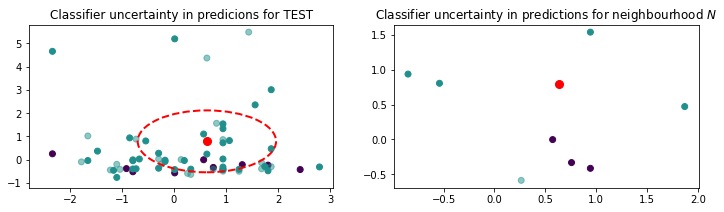

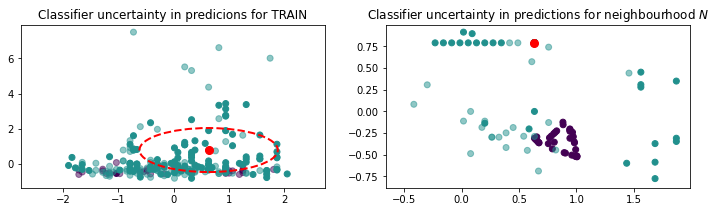

Fidelity  with shap: 0.9473684210526316
f_4>=0.7084940969944
f_4>=0.7084940969944
SHAP coverage: nn: 0.2857142857142857 and local: 0.136986301369863
Full rule: {'rule': {'f_4': ['>= 0.7084940969944']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.5144897788522211
Fidelity  EXPLAN: 0.4615384615384615
LORE expl e = {'f_4': ['<1.0996752381324768', '>=0.4837633967399597'], 'f_0': ['>=-0.2980344295501709'], 'f_9': ['<2.59793221950531']}
f_4<1.0996752381324768 and f_4>=0.4837633967399597 and f_0>=-0.2980344295501709 and f_9<2.59793221950531
f_4<1.0996752381324768 and f_4>=0.4837633967399597 and f_0>=-0.2980344295501709 and f_9<2.59793221950531
Explan coverage: nn: 0.07142857142857142 and local: 0.03424657534246575
Full rule: {'rule': {'f_4': ['>= 0.20773602277040482', '>= 0.4837633967399597', '< 1.0996752381324768'], 'f_0': ['>= -0.2980344295501709'], 'f_9': ['< 2.59793221950531']}, 'prediction': '0', 'confidence': 0.9789473684210528}
SHAPGAIN explan:0.27633336120803914
Fidelity  LOR

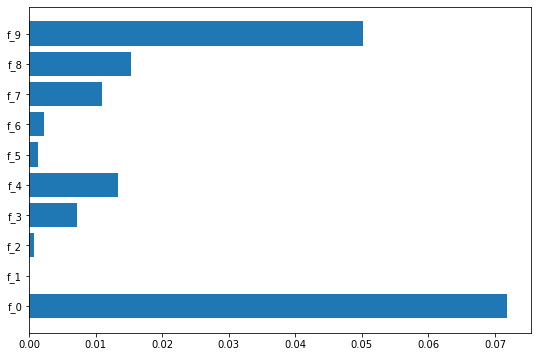

Fidelity  dectree: 0.7058823529411765
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.32558139534883723
--- 0.08585214614868164 seconds ---
IF f_6 >=-0.30973294377326965 AND f_9 <0.6691502630710602 AND f_9 >=-0.10076062008738518 THEN class = 0 # 1.0



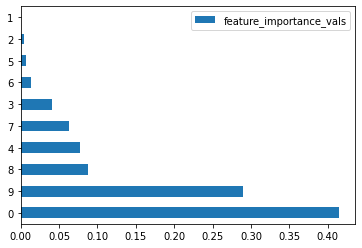

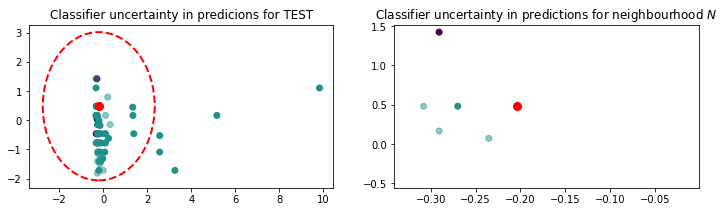

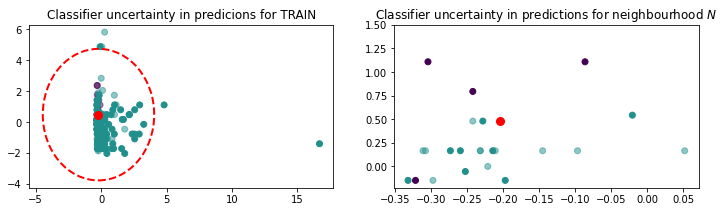

Fidelity  with ablation: 0.823529411764706
f_6>=-0.30973294377326965 and f_9<0.6691502630710602 and f_9>=-0.10076062008738518
f_6>=-0.30973294377326965 and f_9<0.6691502630710602 and f_9>=-0.10076062008738518
SHAP Ablation coverage: nn: 0.5 and local: 0.22602739726027396
Full rule: {'rule': {'f_6': ['>= -0.30973294377326965'], 'f_9': ['< 0.6691502630710602', '>= -0.10076062008738518']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.15150331291411423


Exact explainer: 118it [00:22,  2.91it/s]                         


Done 0.7094017094017094 upsampling
Done 0.9487179487179487 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 313 (0.7162471395881007)
Lux w shap
In fact using: 0.7162471395881007 samples from train set wiuth class balance: 0.5047923322683706


Exact explainer: 164it [00:18,  2.55it/s]                         
Exact explainer: 148it [00:17,  2.32it/s]                         
Exact explainer: 151it [00:29,  3.42it/s]                         
Exact explainer: 136it [00:26,  3.26it/s]                         
Exact explainer: 109it [00:21,  2.73it/s]                         


--- 165.83324360847473 seconds ---
IF f_0 <1.0160568952560425 AND f_0 >=0.3818403333425522 AND f_9 <0.4886583536863327 AND f_8 <0.4881311357021332 AND f_4 >=-0.07859088480472565 THEN class = 0 # 1.0



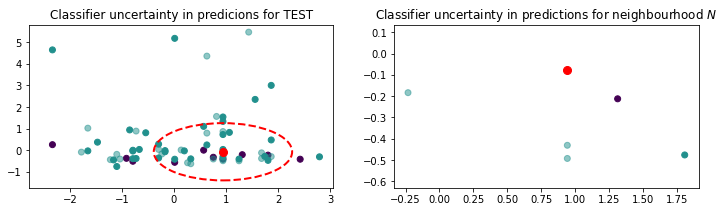

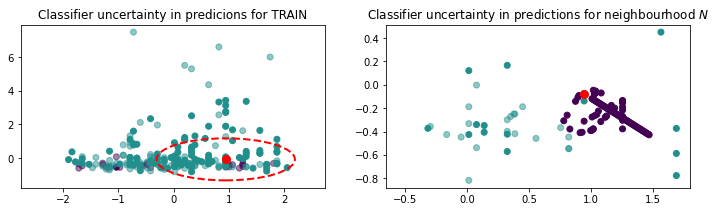

Fidelity  with shap: 0.6666666666666666
f_0<1.0160568952560425 and f_0>=0.3818403333425522 and f_9<0.4886583536863327 and f_8<0.4881311357021332 and f_4>=-0.07859088480472565
f_0<1.0160568952560425 and f_0>=0.3818403333425522 and f_9<0.4886583536863327 and f_8<0.4881311357021332 and f_4>=-0.07859088480472565
SHAP coverage: nn: 0.14285714285714285 and local: 0.1095890410958904
Full rule: {'rule': {'f_0': ['< 1.0160568952560425', '>= 0.3818403333425522'], 'f_9': ['< 0.4886583536863327'], 'f_8': ['< 0.4881311357021332'], 'f_4': ['>= -0.07859088480472565']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.21764439304913125
Fidelity  EXPLAN: 0.6153846153846153
LORE expl e = {'f_2': ['<0.5562689900398254'], 'f_0': ['<1.4767698049545288', '>=0.9021962881088257'], 'f_5': ['>=-0.33000296354293823'], 'f_9': ['<0.767585963010788', '>=-0.4631897807121277'], 'f_8': ['>=-0.2737652510404587'], 'f_7': ['<0.30464988946914673', '>=-0.2601507157087326']}
f_2<0.5562689900398254 and f_0<1.476769804954

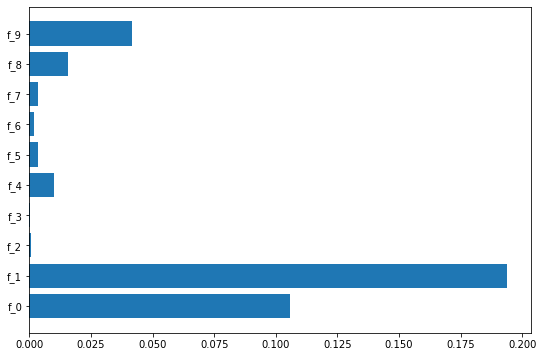

Fidelity  dectree: 0.625
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.46511627906976744
--- 0.10065436363220215 seconds ---
IF f_0 >=1.4375582337379456 AND f_3 >=-0.47614558041095734 AND f_7 <0.15380967780947685 THEN class = 0 # 1.0



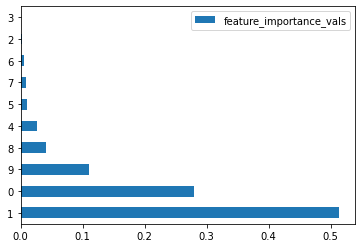

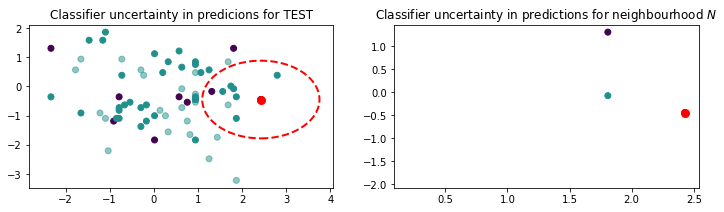

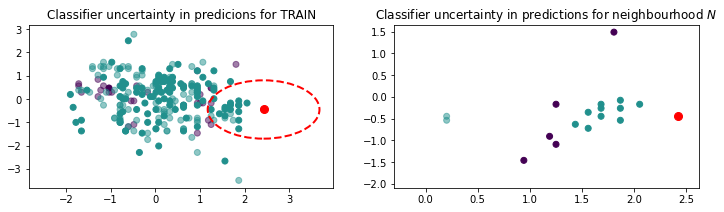

Fidelity  with ablation: 0.3076923076923077
f_0>=1.4375582337379456 and f_3>=-0.47614558041095734 and f_7<0.15380967780947685
f_0>=1.4375582337379456 and f_3>=-0.47614558041095734 and f_7<0.15380967780947685
SHAP Ablation coverage: nn: 0.42857142857142855 and local: 0.0821917808219178
Full rule: {'rule': {'f_0': ['>= 1.4375582337379456'], 'f_3': ['>= -0.47614558041095734'], 'f_7': ['< 0.15380967780947685']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.09682220947281132


Exact explainer: 86it [00:28,  1.95it/s]                        


Done 0.6941176470588235 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 225 (0.5148741418764302)
Lux w shap
In fact using: 0.5148741418764302 samples from train set wiuth class balance: 0.6533333333333333


Exact explainer: 116it [00:46,  1.96it/s]                         
Exact explainer: 81it [00:26,  1.94it/s]                        
Exact explainer: 69it [00:18,  1.75it/s]                        
Exact explainer: 51it [00:10,  5.12s/it]                
Exact explainer: 111it [00:27,  2.99it/s]                         
Exact explainer: 106it [00:24,  3.11it/s]                         


--- 199.51015853881836 seconds ---
IF f_0 >=1.6877481937408447 AND f_8 >=0.010250525549054146 THEN class = 1 # 1.0



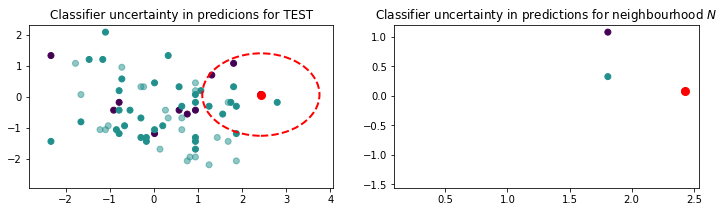

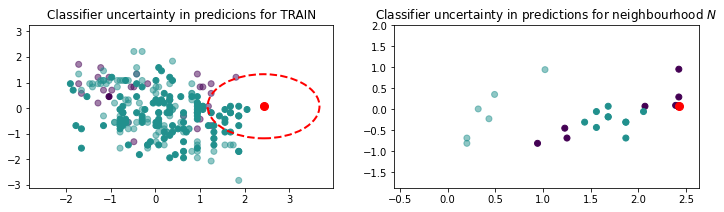

Fidelity  with shap: 0.875
f_0>=1.6877481937408447 and f_8>=0.010250525549054146
f_0>=1.6877481937408447 and f_8>=0.010250525549054146
SHAP coverage: nn: 0.21428571428571427 and local: 0.02054794520547945
Full rule: {'rule': {'f_0': ['>= 1.6877481937408447'], 'f_8': ['>= 0.010250525549054146']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.1606688659399495
Fidelity  EXPLAN: 0.39999999999999997
LORE expl e = {'f_0': ['>=1.2973138093948364'], 'f_1': ['== -1.7622808524230416'], 'f_9': ['>=0.48027390241622925'], 'f_8': ['<0.5651409924030304'], 'f_7': ['>=-0.9526704549789429']}
f_0>=1.2973138093948364 and f_1== -1.7622808524230416 and f_9>=0.48027390241622925 and f_8<0.5651409924030304 and f_7>=-0.9526704549789429
f_0>=1.2973138093948364 and f_1== -1.7622808524230416 and f_9>=0.48027390241622925 and f_8<0.5651409924030304 and f_7>=-0.9526704549789429
Explan coverage: nn: 0.07142857142857142 and local: 0.00684931506849315
Full rule: {'rule': {'f_0': ['>= 1.2973138093948364'], 'f_1': 

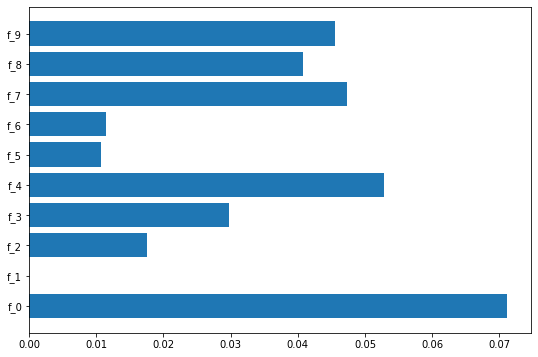

Fidelity  dectree: 0.6666666666666665
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.20930232558139536
--- 0.08976411819458008 seconds ---
IF f_9 <-0.6978342831134796 THEN class = 0 # 1.0



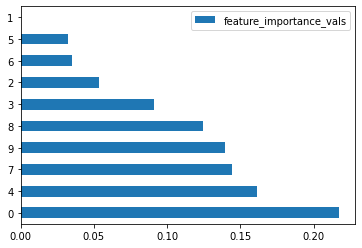

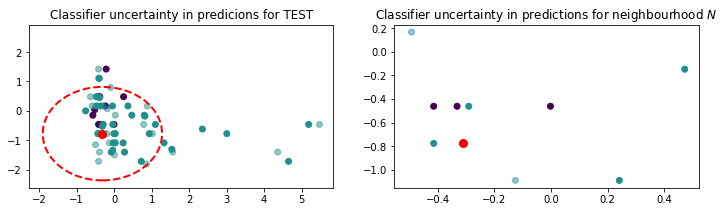

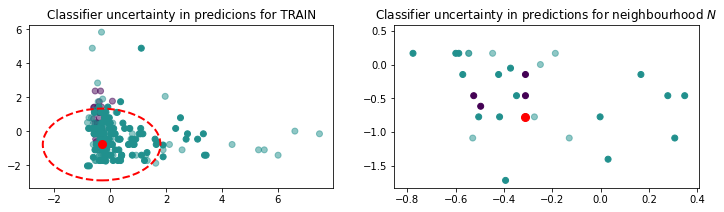

Fidelity  with ablation: 0.4444444444444445
f_9<-0.6978342831134796
f_9<-0.6978342831134796
SHAP Ablation coverage: nn: 0.5 and local: 0.2876712328767123
Full rule: {'rule': {'f_9': ['< -0.6978342831134796']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.13932980599647238


Exact explainer: 86it [00:14,  1.80it/s]                        


Done 0.6 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 233 (0.5331807780320366)
Lux w shap
In fact using: 0.5331807780320366 samples from train set wiuth class balance: 0.463519313304721


Exact explainer: 160it [00:21,  3.19it/s]                         
Exact explainer: 137it [00:15,  2.43it/s]                         
Exact explainer: 75it [00:11,  1.10it/s]                        


--- 84.98739337921143 seconds ---
IF f_2 <-0.2566891610622406 AND f_0 <1.5077423453330994 AND f_0 >=1.3796018362045288 AND f_9 >= 1.202484023478101 * f_3+-0.27363879835010324 AND f_4 >=-0.5173508077859879 AND f_7 <0.4592442661523819 AND f_7 < 5.341366077969765 * f_8+1.5966360020455697 AND f_7 >=0.3094084560871124 THEN class = 1 # 1.0



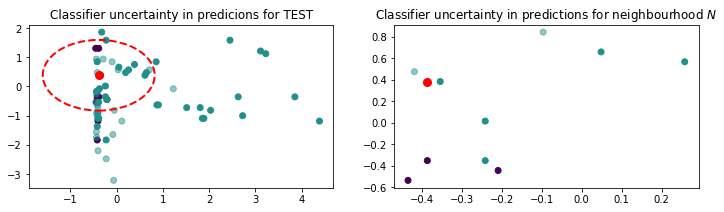

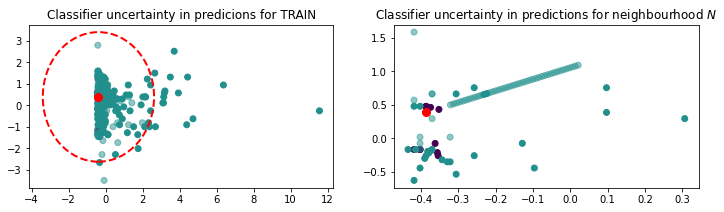

Fidelity  with shap: 0.888888888888889
f_2<-0.2566891610622406 and f_0<1.5077423453330994 and f_0>=1.3796018362045288 and f_9>= 1.202484023478101 * f_3+-0.27363879835010324 and f_4>=-0.5173508077859879 and f_7<0.4592442661523819 and f_7< 5.341366077969765 * f_8+1.5966360020455697 and f_7>=0.3094084560871124
f_2<-0.2566891610622406 and f_0<1.5077423453330994 and f_0>=1.3796018362045288 and f_9>= 1.202484023478101 * f_3+-0.27363879835010324 and f_4>=-0.5173508077859879 and f_7<0.4592442661523819 and f_7< 5.341366077969765 * f_8+1.5966360020455697 and f_7>=0.3094084560871124
SHAP coverage: nn: 0.07142857142857142 and local: 0.00684931506849315
Full rule: {'rule': {'f_2': ['< -0.2566891610622406'], 'f_0': ['< 1.5077423453330994', '>= 0.8587653636932373', '>= 1.3796018362045288'], 'f_9': ['>= 1.202484023478101 * f_3+-0.27363879835010324'], 'f_4': ['>= -0.5173508077859879'], 'f_7': ['< 5.341366077969765 * f_8+1.5966360020455697', '>= 0.3094084560871124', '< 0.4592442661523819']}, 'prediction

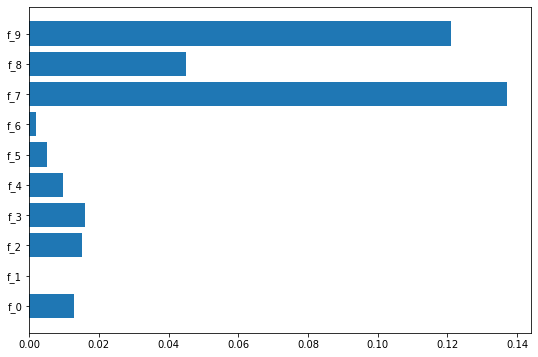

Fidelity  dectree: 0.5555555555555556
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.18604651162790697
--- 0.09366726875305176 seconds ---
IF f_4 >=-0.3669776916503906 AND f_6 <-0.23352152109146118 THEN class = 0 # 1.0



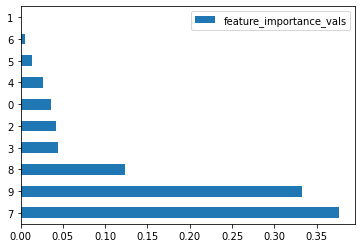

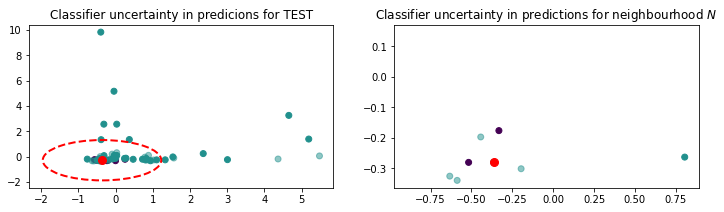

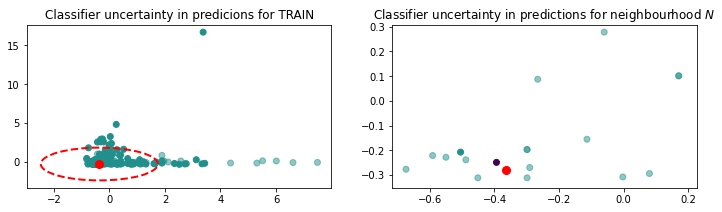

Fidelity  with ablation: 0.6250000000000001
f_4>=-0.3669776916503906 and f_6<-0.23352152109146118
f_4>=-0.3669776916503906 and f_6<-0.23352152109146118
SHAP Ablation coverage: nn: 0.21428571428571427 and local: 0.22602739726027396
Full rule: {'rule': {'f_4': ['>= -0.49675174057483673', '>= -0.3669776916503906'], 'f_6': ['< -0.23352152109146118']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.016102904021638956


Exact explainer: 108it [00:18,  2.64it/s]                         


Done 0.6261682242990654 upsampling
Done 0.9439252336448598 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 275 (0.6292906178489702)
Lux w shap
In fact using: 0.6292906178489702 samples from train set wiuth class balance: 0.23272727272727273


Exact explainer: 201it [00:27,  4.99it/s]                         
Exact explainer: 192it [00:24,  5.05it/s]                         
Exact explainer: 190it [00:24,  4.99it/s]                         


--- 130.19067287445068 seconds ---
IF f_9 >=-0.38851606845855713 AND f_7 <-0.3897610157728195 THEN class = 0 # 0.9895287958115183



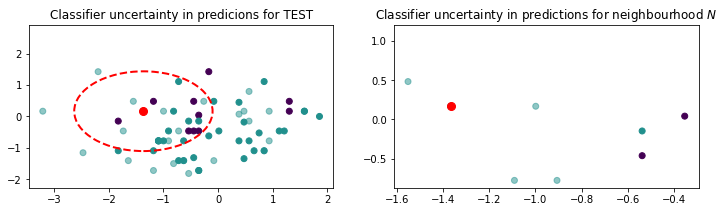

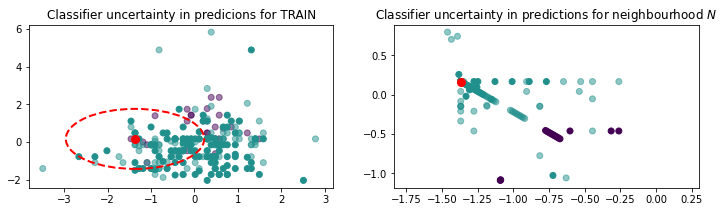

Fidelity  with shap: 0.7777777777777778
f_9>=-0.38851606845855713 and f_7<-0.3897610157728195
f_9>=-0.38851606845855713 and f_7<-0.3897610157728195
SHAP coverage: nn: 0.6428571428571429 and local: 0.14383561643835616
Full rule: {'rule': {'f_9': ['>= -0.38851606845855713'], 'f_7': ['< -0.3897610157728195']}, 'prediction': '0', 'confidence': 0.9895287958115183}
SHAPGAIN LUX:0.35472460838807474
Fidelity  EXPLAN: 0.8421052631578948
LORE expl e = {'f_0': ['<-0.1921158730983734'], 'f_9': ['>=-1.2477704882621765'], 'f_8': ['<-0.038009146228432655'], 'f_4': ['<-0.010043019661679864'], 'f_3': ['<0.04656030982732773'], 'f_6': ['<-0.20955409854650497'], 'f_7': ['<-0.8713594377040863']}
f_0<-0.1921158730983734 and f_9>=-1.2477704882621765 and f_8<-0.038009146228432655 and f_4<-0.010043019661679864 and f_3<0.04656030982732773 and f_6<-0.20955409854650497 and f_7<-0.8713594377040863
f_0<-0.1921158730983734 and f_9>=-1.2477704882621765 and f_8<-0.038009146228432655 and f_4<-0.010043019661679864 and f

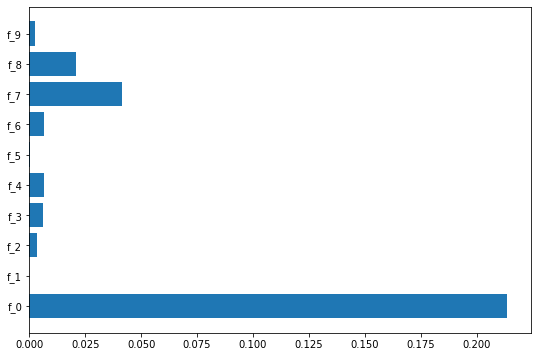

Fidelity  dectree: 0.8571428571428572
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.20930232558139536
--- 0.09662771224975586 seconds ---
IF f_0 >=1.2830077409744263 AND f_6 >=-0.3080008625984192 THEN class = 0 # 1.0



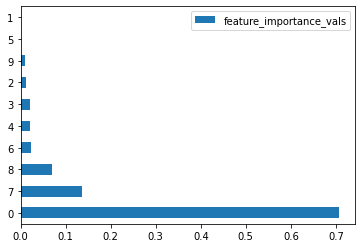

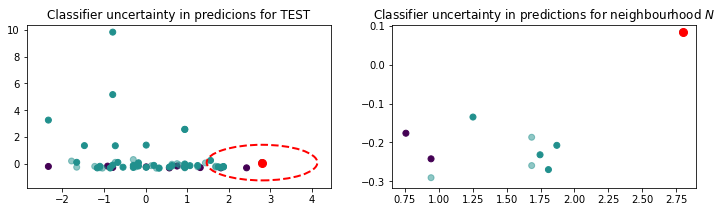

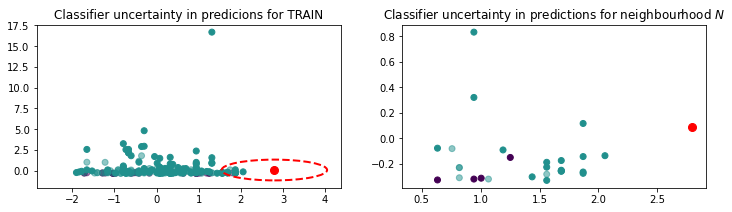

Fidelity  with ablation: 0.8000000000000002
f_0>=1.2830077409744263 and f_6>=-0.3080008625984192
f_0>=1.2830077409744263 and f_6>=-0.3080008625984192
SHAP Ablation coverage: nn: 0.5714285714285714 and local: 0.1232876712328767
Full rule: {'rule': {'f_0': ['>= 1.2830077409744263'], 'f_6': ['>= -0.3080008625984192']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.36521484631649337


Exact explainer: 112it [00:22,  2.71it/s]                         


Done 0.7747747747747747 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 308 (0.7048054919908466)
Lux w shap
In fact using: 0.7048054919908466 samples from train set wiuth class balance: 0.18181818181818182


Exact explainer: 218it [00:38,  4.47it/s]                         
Exact explainer: 188it [00:30,  4.61it/s]                         
Exact explainer: 92it [00:16,  2.14it/s]                        


--- 137.03018593788147 seconds ---
IF f_9 <-0.6978342831134796 THEN class = 0 # 0.9953917050691243



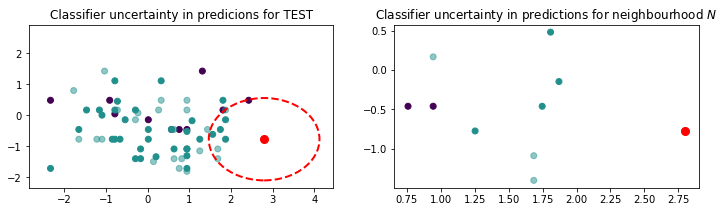

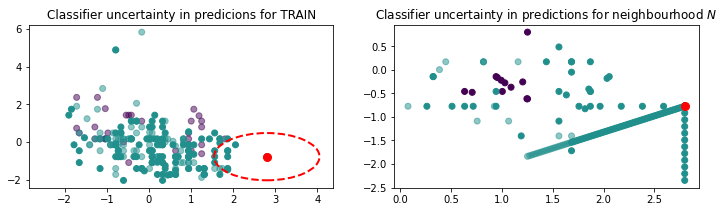

Fidelity  with shap: 0.9
f_9<-0.6978342831134796
f_9<-0.6978342831134796
SHAP coverage: nn: 0.42857142857142855 and local: 0.2876712328767123
Full rule: {'rule': {'f_9': ['< -0.6978342831134796']}, 'prediction': '0', 'confidence': 0.9953917050691243}
SHAPGAIN LUX:0.008875774987755493
Fidelity  EXPLAN: 0.8000000000000002
LORE expl e = {'f_0': ['>=1.96302992105484'], 'f_8': ['<1.0167472660541534']}
f_0>=1.96302992105484 and f_8<1.0167472660541534
f_0>=1.96302992105484 and f_8<1.0167472660541534
Explan coverage: nn: 0.07142857142857142 and local: 0.0136986301369863
Full rule: {'rule': {'f_0': ['>= -0.2006770670413971', '>= 1.96302992105484'], 'f_8': ['< 1.0167472660541534']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN explan:0.388365925625067
Fidelity  LORE: 0.8000000000000002
LORE expl e = {'f_0': ['>=1.269599974155426'], 'f_9': ['<1.9579907059669495'], 'f_1': ['>=-1.1226995587348938']}
Ats lore: ['f_0', 'f_9', 'f_1']
f_0>=1.269599974155426 and f_9<1.9579907059669495 and f_1>=-1.1226

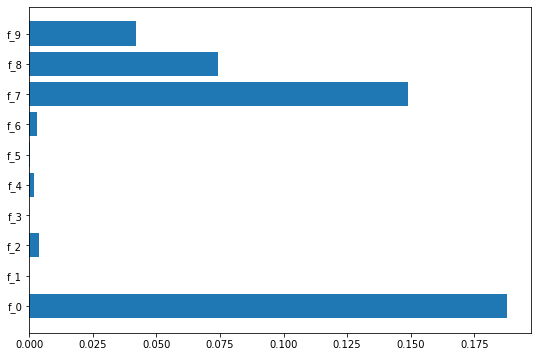

Fidelity  dectree: 0.7368421052631577
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.5116279069767442
--- 0.09350752830505371 seconds ---
IF f_0 <0.8811764419078827 AND f_9 <1.5804731249809265 AND f_4 <-0.3257795721292496 AND f_7 <1.536909818649292 AND f_7 >=0.5226362496614456 THEN class = 0 # 1.0



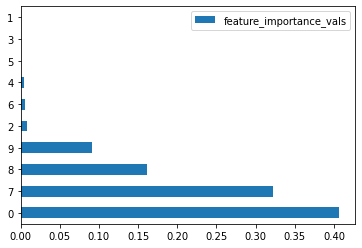

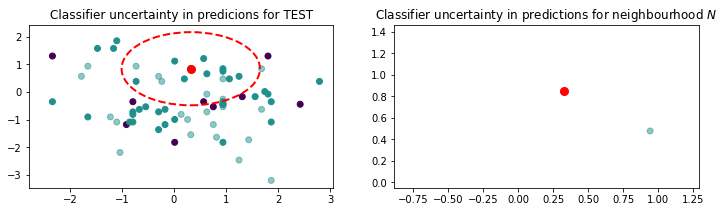

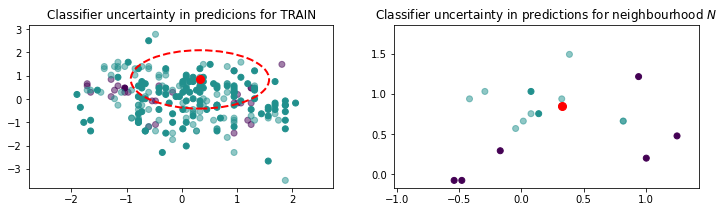

Fidelity  with ablation: 0.7142857142857143
f_0<0.8811764419078827 and f_9<1.5804731249809265 and f_4<-0.3257795721292496 and f_7<1.536909818649292 and f_7>=0.5226362496614456
f_0<0.8811764419078827 and f_9<1.5804731249809265 and f_4<-0.3257795721292496 and f_7<1.536909818649292 and f_7>=0.5226362496614456
SHAP Ablation coverage: nn: 0.35714285714285715 and local: 0.07534246575342465
Full rule: {'rule': {'f_0': ['< 0.8811764419078827'], 'f_9': ['< 1.5804731249809265'], 'f_4': ['< -0.3257795721292496'], 'f_7': ['>= 0.5226362496614456', '< 1.536909818649292']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.20597612595375137


Exact explainer: 110it [00:20,  2.69it/s]                         


Done 0.6788990825688074 upsampling
Done 0.926605504587156 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 284 (0.6498855835240275)
Lux w shap
In fact using: 0.6498855835240275 samples from train set wiuth class balance: 0.23591549295774647


Exact explainer: 218it [00:36,  4.60it/s]                         
Exact explainer: 198it [00:32,  4.50it/s]                         
Exact explainer: 181it [00:26,  4.83it/s]                         


--- 146.6104028224945 seconds ---
IF f_0 <0.8245355188846588 AND f_0 >=-0.2687130719423294 AND f_7 >=0.5048716366291046 THEN class = 0 # 1.0



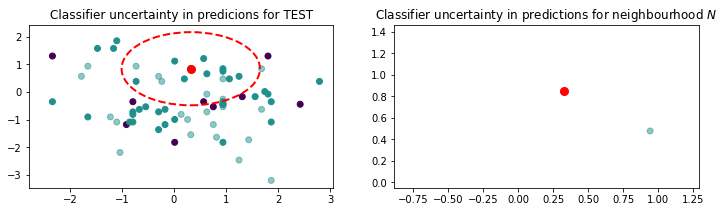

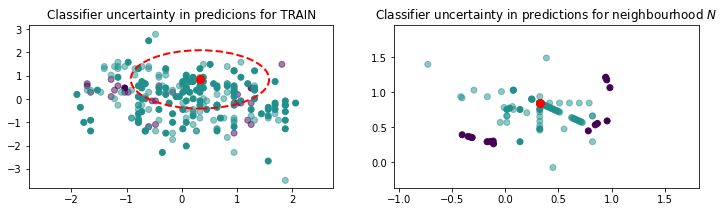

Fidelity  with shap: 0.6666666666666666
f_0<0.8245355188846588 and f_0>=-0.2687130719423294 and f_7>=0.5048716366291046
f_0<0.8245355188846588 and f_0>=-0.2687130719423294 and f_7>=0.5048716366291046
SHAP coverage: nn: 0.2857142857142857 and local: 0.0821917808219178
Full rule: {'rule': {'f_0': ['< 0.8245355188846588', '>= -0.2687130719423294'], 'f_7': ['>= 0.5048716366291046']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.36450873507383996
Fidelity  EXPLAN: 0.7368421052631577
LORE expl e = {'f_0': ['<0.6029855310916901', '>=0.23206433653831482'], 'f_9': ['>=1.097385287284851'], 'f_8': ['>=0.1360626295208931'], 'f_7': ['>=-0.20308645069599152']}
f_0<0.6029855310916901 and f_0>=0.23206433653831482 and f_9>=1.097385287284851 and f_8>=0.1360626295208931 and f_7>=-0.20308645069599152
f_0<0.6029855310916901 and f_0>=0.23206433653831482 and f_9>=1.097385287284851 and f_8>=0.1360626295208931 and f_7>=-0.20308645069599152
Explan coverage: nn: 0.14285714285714285 and local: 0.020547945

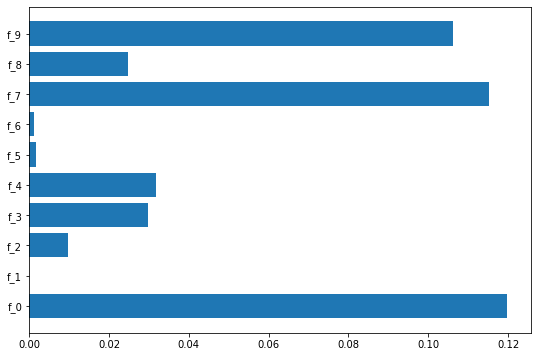

Fidelity  dectree: 0.7058823529411765
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.32558139534883723
--- 0.10889005661010742 seconds ---
IF f_2 <-0.2657556086778641 AND f_2 >=-0.39470064640045166 AND f_0 <-0.8806992471218109 AND f_9 <0.637725368142128 AND f_6 <-0.16077425330877304 THEN class = 0 # 1.0



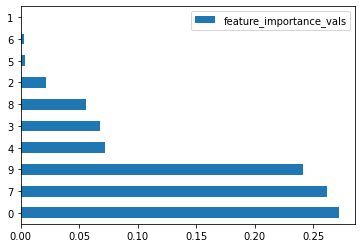

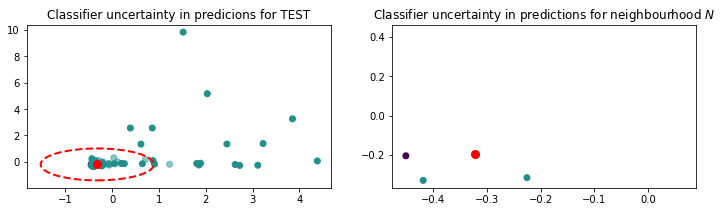

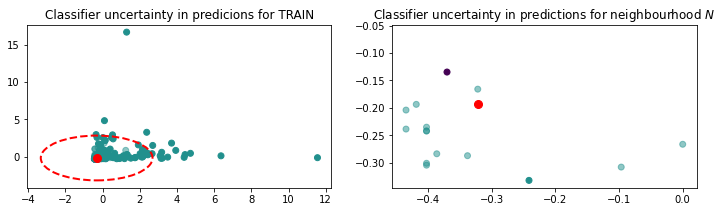

Fidelity  with ablation: 0.631578947368421
f_2<-0.2657556086778641 and f_2>=-0.39470064640045166 and f_0<-0.8806992471218109 and f_9<0.637725368142128 and f_6<-0.16077425330877304
f_2<-0.2657556086778641 and f_2>=-0.39470064640045166 and f_0<-0.8806992471218109 and f_9<0.637725368142128 and f_6<-0.16077425330877304
SHAP Ablation coverage: nn: 0.14285714285714285 and local: 0.02054794520547945
Full rule: {'rule': {'f_2': ['< -0.2657556086778641', '>= -0.39470064640045166'], 'f_0': ['< -0.8806992471218109'], 'f_9': ['< 0.637725368142128'], 'f_6': ['< -0.16077425330877304']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.13457567115743918


Exact explainer: 102it [00:16,  2.39it/s]                         


Done 0.6435643564356436 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 267 (0.6109839816933639)
Lux w shap
In fact using: 0.6109839816933639 samples from train set wiuth class balance: 0.18352059925093633


Exact explainer: 91it [00:13,  1.68it/s]                        
Exact explainer: 178it [00:22,  5.26it/s]                         
Exact explainer: 164it [00:19,  5.54it/s]                         


--- 103.94105291366577 seconds ---
IF f_9 <0.4042927324771881 AND f_8 >=1.7528808116912842 THEN class = 0 # 1.0



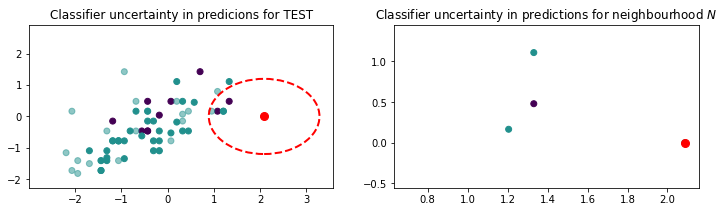

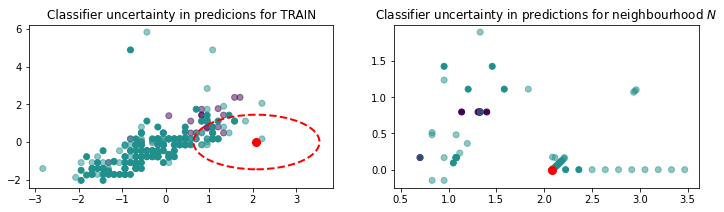

Fidelity  with shap: 0.7368421052631577
f_9<0.4042927324771881 and f_8>=1.7528808116912842
f_9<0.4042927324771881 and f_8>=1.7528808116912842
SHAP coverage: nn: 0.07142857142857142 and local: 0.00684931506849315
Full rule: {'rule': {'f_9': ['< 1.0373976230621338', '< 0.4042927324771881'], 'f_8': ['>= 1.7528808116912842']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.14876094011210553
Fidelity  EXPLAN: 0.823529411764706
LORE expl e = {'f_2': ['>=-0.3755936324596405'], 'f_0': ['>=-1.0987991094589233'], 'f_8': ['>=0.8303973972797394'], 'f_4': ['<0.14051568508148193'], 'f_3': ['<0.5976519584655762', '>=-0.3159704953432083'], 'f_6': ['<1.5522507429122925'], 'f_7': ['>=-1.137083888053894']}
f_2>=-0.3755936324596405 and f_0>=-1.0987991094589233 and f_8>=0.8303973972797394 and f_4<0.14051568508148193 and f_3<0.5976519584655762 and f_3>=-0.3159704953432083 and f_6<1.5522507429122925 and f_7>=-1.137083888053894
f_2>=-0.3755936324596405 and f_0>=-1.0987991094589233 and f_8>=0.83039739727

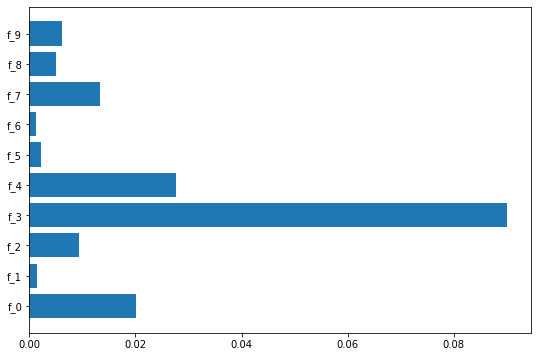

Fidelity  dectree: 0.8799999999999999
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.023255813953488372
--- 0.05927896499633789 seconds ---
IF  THEN class = 0 # 0.9767441860465116

Fidelity  with ablation: 0.923076923076923
SHAP Ablation coverage: nn: 1 and local: 1
Full rule: {'rule': {}, 'prediction': '0', 'confidence': 0.9767441860465116}
SHAPGAIN LUX Ablation:nan


Exact explainer: 150it [00:28,  3.40it/s]                         


Done 0.8859060402684564 upsampling
Done 0.9463087248322147 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 422 (0.965675057208238)
Lux w shap
In fact using: 0.965675057208238 samples from train set wiuth class balance: 0.1990521327014218


Exact explainer: 158it [00:30,  3.56it/s]                         
Exact explainer: 116it [00:21,  2.92it/s]                         
Exact explainer: 105it [00:18,  2.67it/s]                         
Exact explainer: 99it [00:17,  2.44it/s]                        
Exact explainer: 94it [00:15,  2.20it/s]                        
Exact explainer: 79it [00:10,  1.79s/it]                        
Exact explainer: 266it [00:39,  5.36it/s]                         


--- 209.08928966522217 seconds ---
IF f_3 >=0.5380682349205017 THEN class = 0 # 1.0



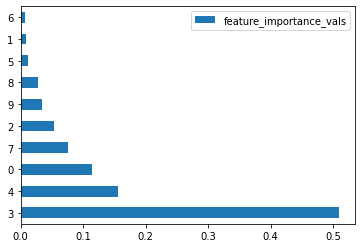

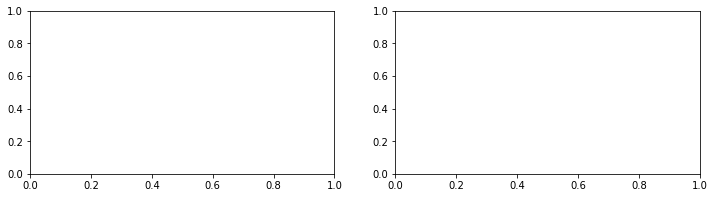

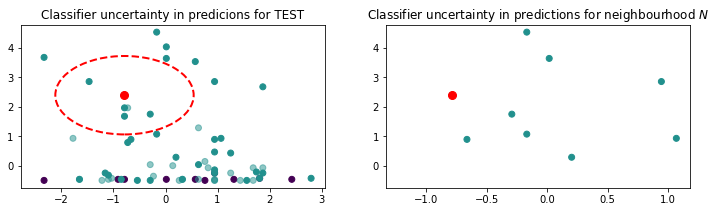

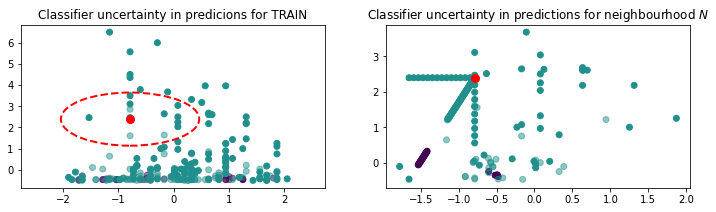

Fidelity  with shap: 0.8333333333333334
f_3>=0.5380682349205017
f_3>=0.5380682349205017
SHAP coverage: nn: 0.5714285714285714 and local: 0.14383561643835616
Full rule: {'rule': {'f_3': ['>= 0.5380682349205017']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.5100778043251846
Fidelity  EXPLAN: 0.9600000000000001
LORE expl e = {'f_2': ['>=-0.4043758660554886'], 'f_0': ['<-0.4171634763479233'], 'f_1': ['== 0.5674464422768072'], 'f_4': ['>=-0.007287373533472419'], 'f_7': ['<-0.31040939688682556']}
f_2>=-0.4043758660554886 and f_0<-0.4171634763479233 and f_1== 0.5674464422768072 and f_4>=-0.007287373533472419 and f_7<-0.31040939688682556
f_2>=-0.4043758660554886 and f_0<-0.4171634763479233 and f_1== 0.5674464422768072 and f_4>=-0.007287373533472419 and f_7<-0.31040939688682556
Explan coverage: nn: 0.14285714285714285 and local: 0.0273972602739726
Full rule: {'rule': {'f_2': ['>= -0.4043758660554886'], 'f_0': ['< -0.4171634763479233'], 'f_1': ['== 0.5674464422768072'], 'f_4': ['>= -0.

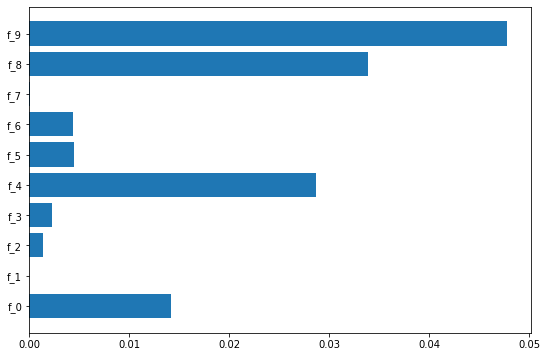

Fidelity  dectree: 0.625
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.46511627906976744
--- 0.1157829761505127 seconds ---
IF f_4 <-0.5709083676338196 THEN class = 0 # 0.6666666666666666



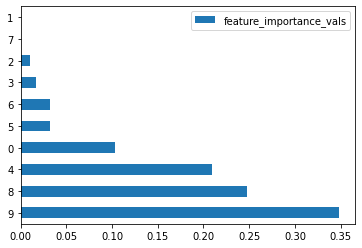

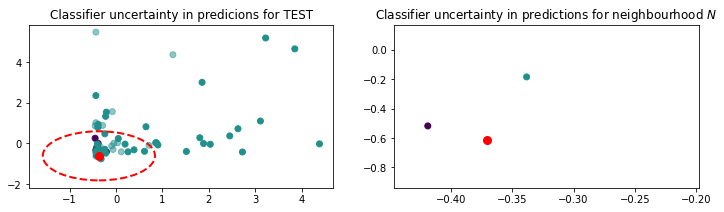

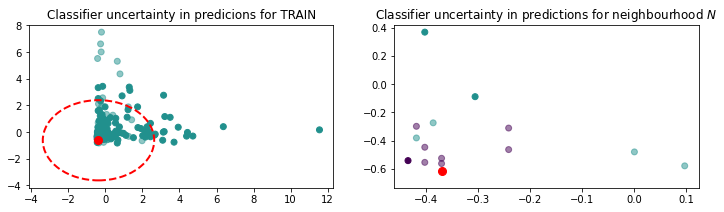

Fidelity  with ablation: 0.5333333333333333
f_4<-0.5709083676338196
f_4<-0.5709083676338196
SHAP Ablation coverage: nn: 0.2857142857142857 and local: 0.0821917808219178
Full rule: {'rule': {'f_4': ['< -0.5111710727214813', '< -0.5709083676338196']}, 'prediction': '0', 'confidence': 0.6666666666666666}
SHAPGAIN LUX Ablation:0.20879800105207708


Exact explainer: 86it [00:13,  1.68it/s]                        


Done 0.5764705882352941 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 215 (0.4919908466819222)
Lux w shap
In fact using: 0.4919908466819222 samples from train set wiuth class balance: 0.6558139534883721


Exact explainer: 185it [00:29,  3.94it/s]                         
Exact explainer: 164it [00:24,  3.65it/s]                         
Exact explainer: 154it [00:21,  3.44it/s]                         


--- 97.24357342720032 seconds ---
IF f_0 <-0.9425194561481476 AND f_9 <1.1867374181747437 AND f_8 <0.7562330961227417 THEN class = 1 # 0.8954248366013072



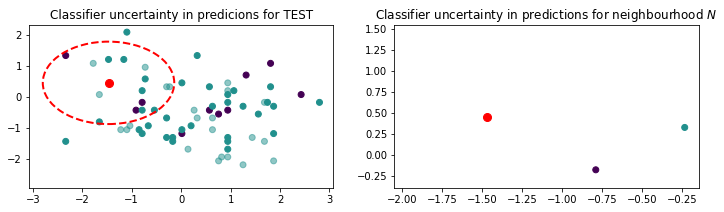

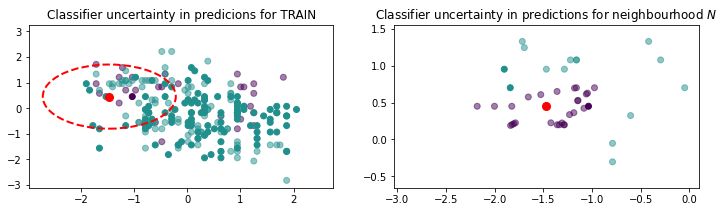

Fidelity  with shap: 0.4285714285714285
f_0<-0.9425194561481476 and f_9<1.1867374181747437 and f_8<0.7562330961227417
f_0<-0.9425194561481476 and f_9<1.1867374181747437 and f_8<0.7562330961227417
SHAP coverage: nn: 0.2857142857142857 and local: 0.11643835616438356
Full rule: {'rule': {'f_0': ['< -0.9425194561481476'], 'f_9': ['< 1.1867374181747437'], 'f_8': ['< 0.7562330961227417']}, 'prediction': '1', 'confidence': 0.8954248366013072}
SHAPGAIN LUX:0.23306593021216884
Fidelity  EXPLAN: 0.8421052631578948
LORE expl e = {'f_0': ['<-0.5715982615947723', '>=-1.9316426515579224'], 'f_9': ['<1.2662239074707031'], 'f_5': ['<0.45645497739315033'], 'f_8': ['>=-0.05120483599603176'], 'f_4': ['<-0.42053523659706116'], 'f_3': ['<0.30786406993865967'], 'f_7': ['<0.8509141802787781']}
f_0<-0.5715982615947723 and f_0>=-1.9316426515579224 and f_9<1.2662239074707031 and f_5<0.45645497739315033 and f_8>=-0.05120483599603176 and f_4<-0.42053523659706116 and f_3<0.30786406993865967 and f_7<0.8509141802787

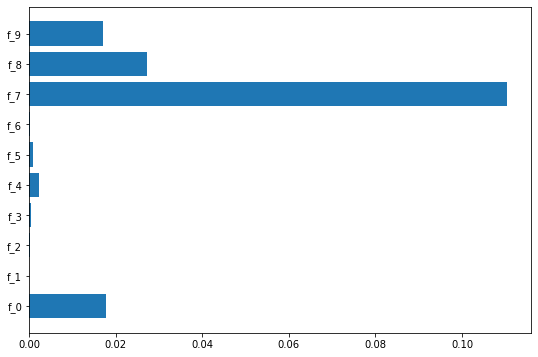

Fidelity  dectree: 0.4
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.3488372093023256
--- 0.08149933815002441 seconds ---
IF f_9 <0.5748753696680069 AND f_8 >=-0.11556158028542995 THEN class = 0 # 0.9310344827586207



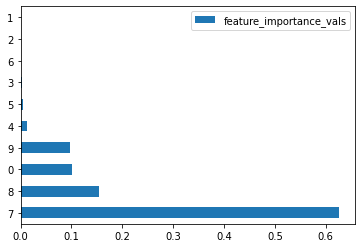

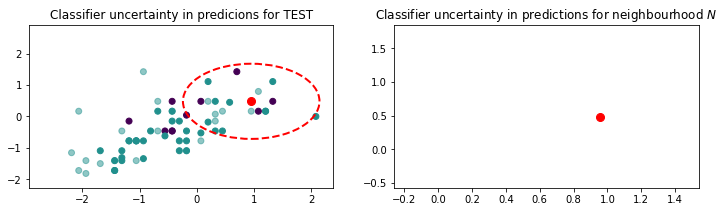

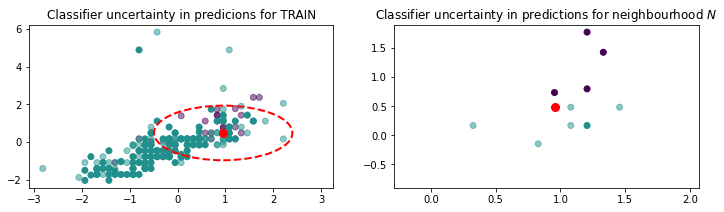

Fidelity  with ablation: 0.5454545454545454
f_9<0.5748753696680069 and f_8>=-0.11556158028542995
f_9<0.5748753696680069 and f_8>=-0.11556158028542995
SHAP Ablation coverage: nn: 0.6428571428571429 and local: 0.3150684931506849
Full rule: {'rule': {'f_9': ['< 0.5748753696680069'], 'f_8': ['>= -0.11556158028542995']}, 'prediction': '0', 'confidence': 0.9310344827586207}
SHAPGAIN LUX Ablation:0.12536335721596717


Exact explainer: 86it [00:14,  1.74it/s]                        


Done 0.6823529411764706 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 237 (0.5423340961098398)
Lux w shap
In fact using: 0.5423340961098398 samples from train set wiuth class balance: 0.47257383966244726


Exact explainer: 105it [00:21,  2.64it/s]                         
Exact explainer: 85it [00:14,  1.93it/s]                        
Exact explainer: 134it [00:14,  2.20it/s]                         
Exact explainer: 118it [00:11,  1.56it/s]                         
Exact explainer: 115it [00:12,  1.64it/s]                         


--- 93.46683359146118 seconds ---
IF f_0 >=-0.2983868420124054 AND f_9 >=0.4584183692932129 AND f_7 <0.7937619388103485 THEN class = 1 # 0.868421052631579



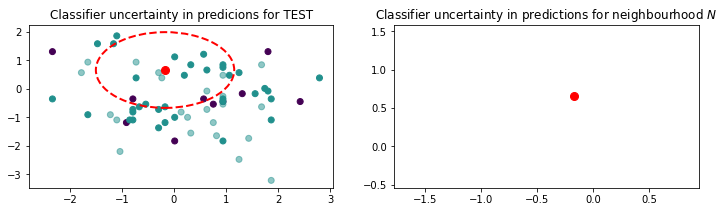

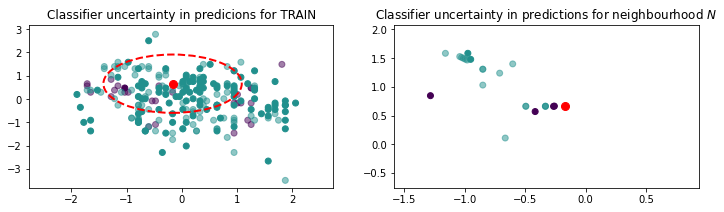

Fidelity  with shap: 0.5
f_0>=-0.2983868420124054 and f_9>=0.4584183692932129 and f_7<0.7937619388103485
f_0>=-0.2983868420124054 and f_9>=0.4584183692932129 and f_7<0.7937619388103485
SHAP coverage: nn: 0.21428571428571427 and local: 0.1506849315068493
Full rule: {'rule': {'f_0': ['>= -0.2983868420124054'], 'f_9': ['>= 0.4584183692932129'], 'f_7': ['< 0.7937619388103485']}, 'prediction': '1', 'confidence': 0.868421052631579}
SHAPGAIN LUX:0.2746741726373252
Fidelity  EXPLAN: 0.5
LORE expl e = {'f_0': ['<0.6101104915142059'], 'f_1': ['== -1.7622808524230416'], 'f_9': ['>=0.4778188318014145'], 'f_8': ['<1.1425592303276062'], 'f_6': ['<-0.29737770557403564'], 'f_7': ['>=0.6404764950275421']}
f_0<0.6101104915142059 and f_1== -1.7622808524230416 and f_9>=0.4778188318014145 and f_8<1.1425592303276062 and f_6<-0.29737770557403564 and f_7>=0.6404764950275421
f_0<0.6101104915142059 and f_1== -1.7622808524230416 and f_9>=0.4778188318014145 and f_8<1.1425592303276062 and f_6<-0.29737770557403564 

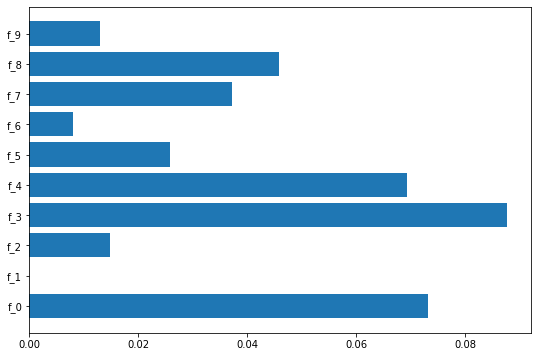

Fidelity  dectree: 0.9166666666666666
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.046511627906976744
--- 0.06624746322631836 seconds ---
IF f_7 <1.1219797134399414 THEN class = 0 # 1.0



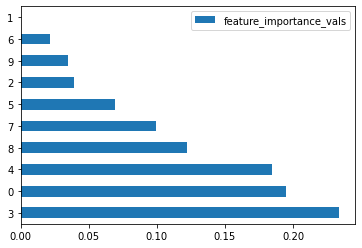

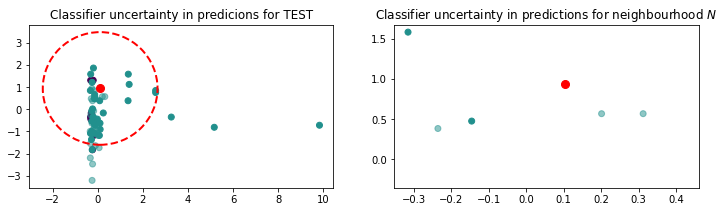

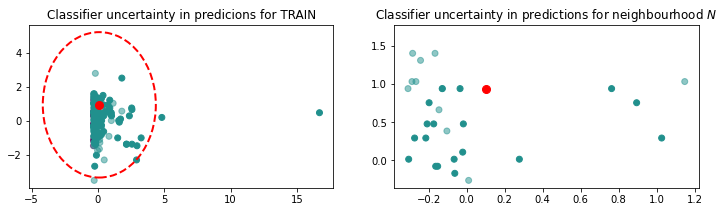

Fidelity  with ablation: 0.8799999999999999
f_7<1.1219797134399414
f_7<1.1219797134399414
SHAP Ablation coverage: nn: 0.7857142857142857 and local: 0.8972602739726028
Full rule: {'rule': {'f_7': ['< 1.1219797134399414']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.0992956933379517


Exact explainer: 144it [00:26,  3.34it/s]                         


Done 0.8811188811188811 upsampling
Done 0.986013986013986 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 410 (0.9382151029748284)
Lux w shap
In fact using: 0.9382151029748284 samples from train set wiuth class balance: 0.35609756097560974


Exact explainer: 251it [00:51,  4.06it/s]                         
Exact explainer: 145it [00:29,  3.40it/s]                         
Exact explainer: 84it [00:14,  2.02it/s]                        
Exact explainer: 107it [00:19,  2.66it/s]                         
Exact explainer: 78it [00:11,  1.25s/it]                        
Exact explainer: 161it [00:17,  3.31it/s]                         


--- 209.26509857177734 seconds ---
IF f_4 >=0.7011050581932068 THEN class = 0 # 1.0



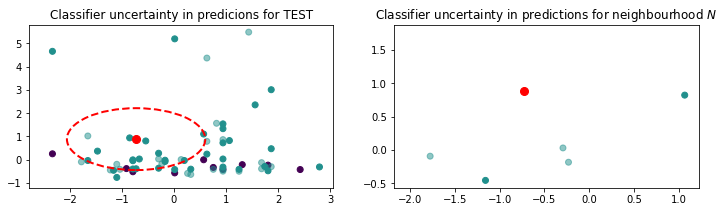

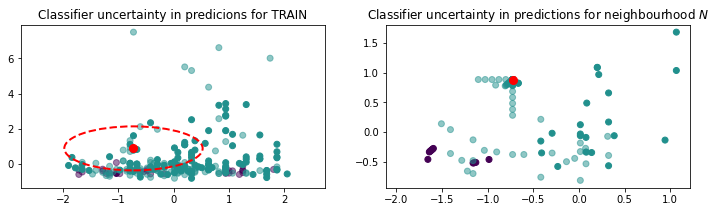

Fidelity  with shap: 0.8799999999999999
f_4>=0.7011050581932068
f_4>=0.7011050581932068
SHAP coverage: nn: 0.21428571428571427 and local: 0.136986301369863
Full rule: {'rule': {'f_4': ['>= 0.7011050581932068']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.18480833621983583
Fidelity  EXPLAN: 0.761904761904762
LORE expl e = {'f_4': ['>=0.8380671739578247'], 'f_1': ['== 0.5674464422768072'], 'f_9': ['<0.9519745409488678']}
f_4>=0.8380671739578247 and f_1== 0.5674464422768072 and f_9<0.9519745409488678
f_4>=0.8380671739578247 and f_1== 0.5674464422768072 and f_9<0.9519745409488678
Explan coverage: nn: 0.14285714285714285 and local: 0.06164383561643835
Full rule: {'rule': {'f_4': ['>= 0.20534731447696686', '>= 0.8380671739578247'], 'f_1': ['== 0.5674464422768072'], 'f_9': ['< 0.9519745409488678']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN explan:0.07318246545818412
Fidelity  LORE: 0.6
LORE expl e = {'f_0': ['>=-2.5727357864379883'], 'f_9': ['<0.6295333206653595'], 'f_8': ['<1

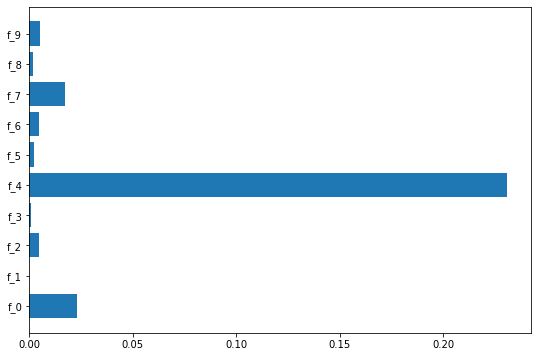

Fidelity  dectree: 0.7999999999999999
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.16279069767441862
--- 0.07990455627441406 seconds ---
IF f_0 <-0.07703666295856237 AND f_8 <-0.8704339265823364 AND f_4 >=-0.5029314607381821 AND f_6 <-0.23352152109146118 THEN class = 1 # 1.0



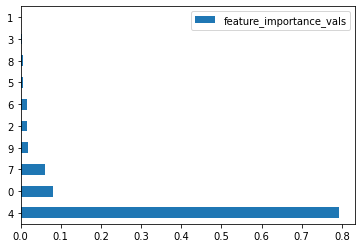

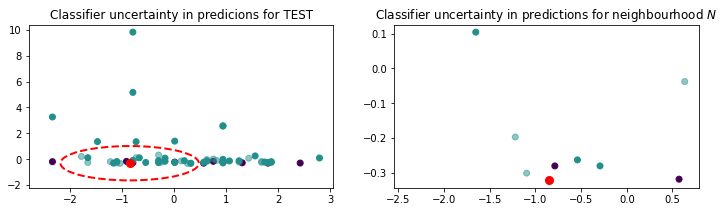

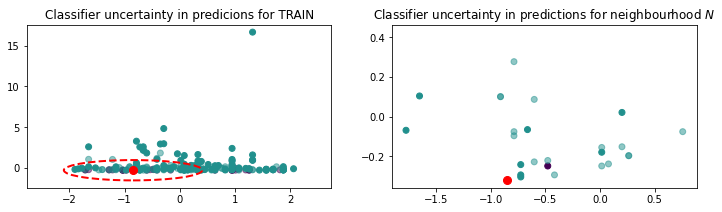

Fidelity  with ablation: 0.7368421052631577
f_0<-0.07703666295856237 and f_8<-0.8704339265823364 and f_4>=-0.5029314607381821 and f_6<-0.23352152109146118
f_0<-0.07703666295856237 and f_8<-0.8704339265823364 and f_4>=-0.5029314607381821 and f_6<-0.23352152109146118
SHAP Ablation coverage: nn: 0.21428571428571427 and local: 0.0410958904109589
Full rule: {'rule': {'f_0': ['< -0.07703666295856237'], 'f_8': ['< -0.8704339265823364'], 'f_4': ['>= -0.5029314607381821'], 'f_6': ['< -0.23352152109146118']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.22399981391886875


Exact explainer: 120it [00:21,  3.00it/s]                         


Done 0.7647058823529411 upsampling
Done 0.9327731092436975 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 321 (0.7345537757437071)
Lux w shap
In fact using: 0.7345537757437071 samples from train set wiuth class balance: 0.27414330218068533


Exact explainer: 142it [00:27,  3.41it/s]                         
Exact explainer: 107it [00:20,  2.86it/s]                         
Exact explainer: 98it [00:17,  2.61it/s]                        
Exact explainer: 181it [00:28,  4.82it/s]                         


--- 136.34727096557617 seconds ---
IF f_4 >=0.11034345999360085 THEN class = 0 # 1.0



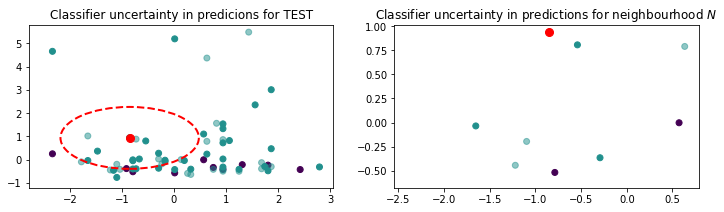

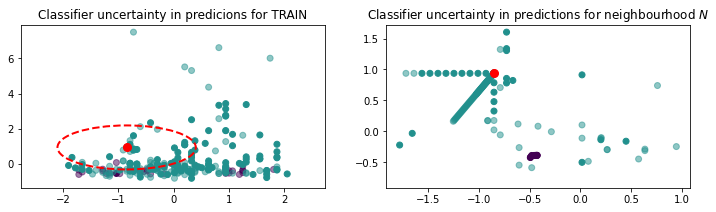

Fidelity  with shap: 0.9
f_4>=0.11034345999360085
f_4>=0.11034345999360085
SHAP coverage: nn: 0.21428571428571427 and local: 0.2191780821917808
Full rule: {'rule': {'f_4': ['>= 0.11034345999360085']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.7940081875697809
Fidelity  EXPLAN: 0.5714285714285714
LORE expl e = {'f_4': ['>=0.8772054016590118'], 'f_0': ['<-0.18325888365507126']}
f_4>=0.8772054016590118 and f_0<-0.18325888365507126
f_4>=0.8772054016590118 and f_0<-0.18325888365507126
Explan coverage: nn: 0.07142857142857142 and local: 0.03424657534246575
Full rule: {'rule': {'f_4': ['>= 0.17683743685483932', '>= 0.8772054016590118'], 'f_0': ['< -0.18325888365507126']}, 'prediction': '0', 'confidence': 0.9795918367346939}
SHAPGAIN explan:0.4370301451432827
Fidelity  LORE: 0.6666666666666666
LORE expl e = {'f_4': ['>=0.08397716283798218'], 'f_1': ['>=-1.4563993215560913']}
Ats lore: ['f_4', 'f_1']
f_4>=0.08397716283798218 and f_1>=-1.4563993215560913
f_4>=0.08397716283798218 and f

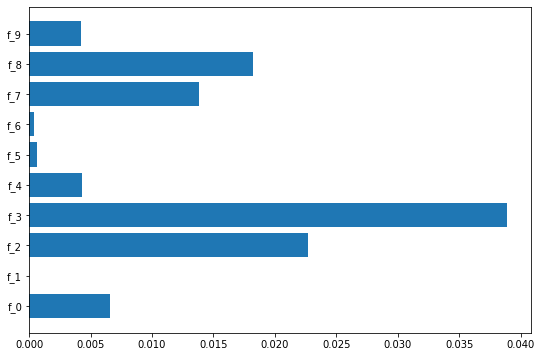

Fidelity  dectree: 0.5555555555555556
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.3488372093023256
--- 0.10279226303100586 seconds ---
IF f_4 >=-0.15480739250779152 THEN class = 0 # 1.0



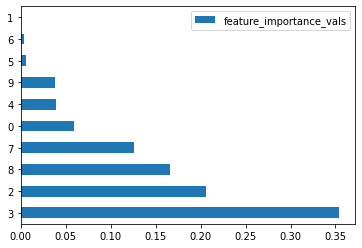

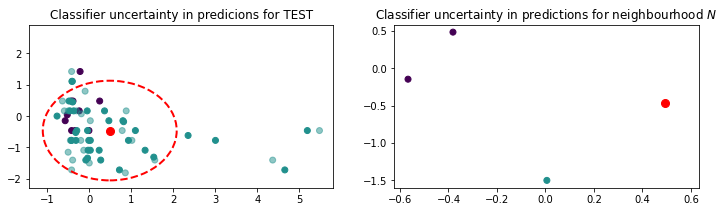

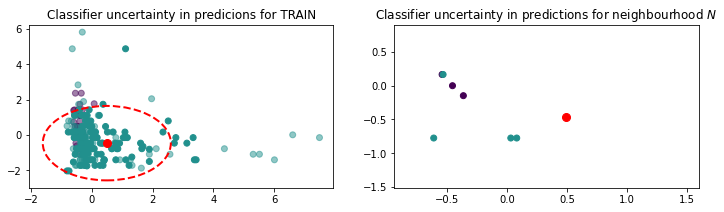

Fidelity  with ablation: 0.7058823529411765
f_4>=-0.15480739250779152
f_4>=-0.15480739250779152
SHAP Ablation coverage: nn: 0.35714285714285715 and local: 0.3835616438356164
Full rule: {'rule': {'f_4': ['>= -0.15480739250779152']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.039043772370538125


Exact explainer: 94it [00:32,  1.99it/s]                        


Done 0.7204301075268817 upsampling
Done 0.978494623655914 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 251 (0.5743707093821511)
Lux w shap
In fact using: 0.5743707093821511 samples from train set wiuth class balance: 0.4063745019920319


Exact explainer: 221it [01:11,  2.74it/s]                         
Exact explainer: 167it [00:51,  2.40it/s]                         
Exact explainer: 147it [00:37,  2.18it/s]                         
Exact explainer: 102it [00:14,  1.11s/it]                         
Exact explainer: 95it [00:14,  1.10s/it]                        
Exact explainer: 93it [00:13,  1.16s/it]                        


--- 276.09519720077515 seconds ---
IF f_0 >=-0.5187519639730453 AND f_9 <-0.11298132874071598 AND f_8 >=-0.3881543278694153 AND f_4 >=0.027938615006860346 AND f_3 >=-0.3850737512111664 AND f_7 <0.10183705389499664 AND f_7 >=-0.8351814448833466 THEN class = 0 # 0.984126984126984



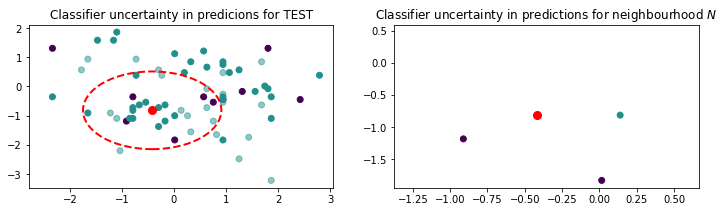

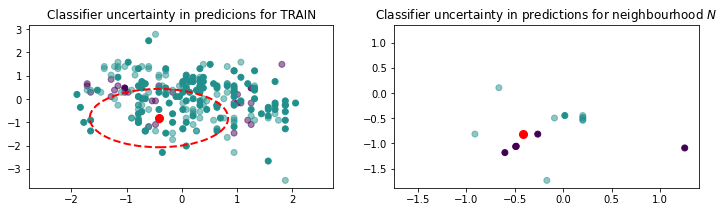

Fidelity  with shap: 0.7777777777777777
f_0>=-0.5187519639730453 and f_9<-0.11298132874071598 and f_8>=-0.3881543278694153 and f_4>=0.027938615006860346 and f_3>=-0.3850737512111664 and f_7<0.10183705389499664 and f_7>=-0.8351814448833466
f_0>=-0.5187519639730453 and f_9<-0.11298132874071598 and f_8>=-0.3881543278694153 and f_4>=0.027938615006860346 and f_3>=-0.3850737512111664 and f_7<0.10183705389499664 and f_7>=-0.8351814448833466
SHAP coverage: nn: 0.07142857142857142 and local: 0.0136986301369863
Full rule: {'rule': {'f_0': ['>= -0.5187519639730453'], 'f_9': ['< -0.11298132874071598'], 'f_8': ['>= -0.3881543278694153'], 'f_4': ['>= -0.47888587415218353', '>= 0.027938615006860346'], 'f_3': ['>= -0.44717444479465485', '>= -0.3850737512111664'], 'f_7': ['>= -1.3210015892982483', '>= -0.8351814448833466', '< 0.10183705389499664']}, 'prediction': '0', 'confidence': 0.984126984126984}
SHAPGAIN LUX:0.13055637649273752
Fidelity  EXPLAN: 0.7000000000000001
LORE expl e = {'f_0': ['<0.819125

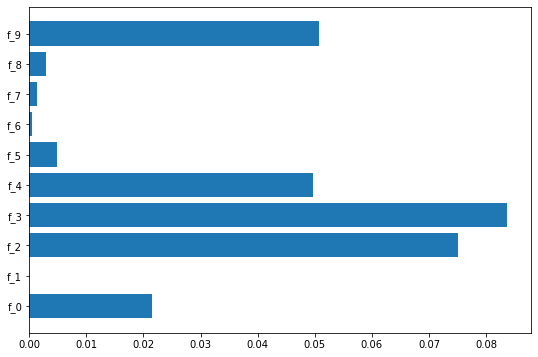

Fidelity  dectree: 0.8799999999999999
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.13953488372093023
--- 0.07727646827697754 seconds ---
IF f_2 >=-0.31410999596118927 THEN class = 0 # 0.9705882352941175



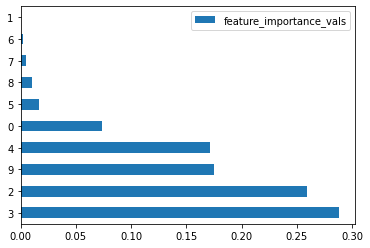

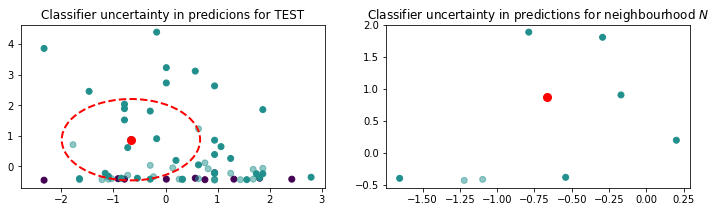

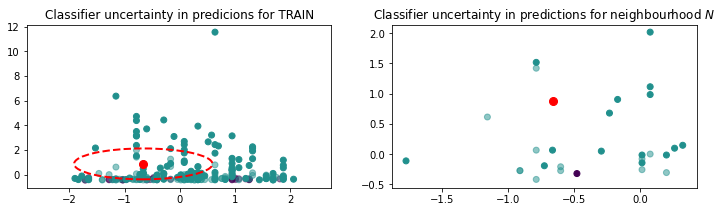

Fidelity  with ablation: 0.7826086956521738
f_2>=-0.31410999596118927
f_2>=-0.31410999596118927
SHAP Ablation coverage: nn: 0.6428571428571429 and local: 0.410958904109589
Full rule: {'rule': {'f_2': ['>= -0.31410999596118927']}, 'prediction': '0', 'confidence': 0.9705882352941175}
SHAPGAIN LUX Ablation:0.25864082494719837


Exact explainer: 116it [00:21,  2.84it/s]                         


Done 0.8869565217391304 upsampling
Done 0.9652173913043478 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 328 (0.7505720823798627)
Lux w shap
In fact using: 0.7505720823798627 samples from train set wiuth class balance: 0.2225609756097561


Exact explainer: 123it [00:23,  3.10it/s]                         
Exact explainer: 83it [00:13,  1.65it/s]                        
Exact explainer: 207it [00:31,  4.85it/s]                         
Exact explainer: 189it [00:27,  4.91it/s]                         


--- 148.61568665504456 seconds ---
IF f_3 >=0.1050615906715393 AND f_9 <-0.2917657792568207 THEN class = 0 # 1.0



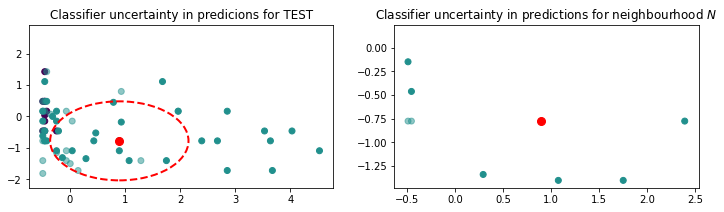

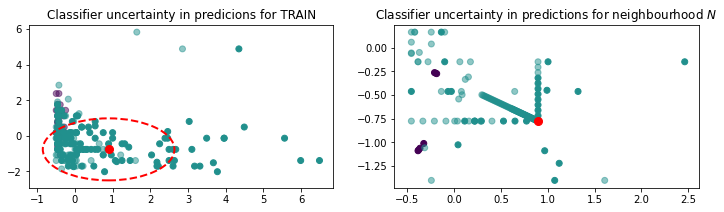

Fidelity  with shap: 0.8333333333333334
f_3>=0.1050615906715393 and f_9<-0.2917657792568207
f_3>=0.1050615906715393 and f_9<-0.2917657792568207
SHAP coverage: nn: 0.35714285714285715 and local: 0.1232876712328767
Full rule: {'rule': {'f_3': ['>= 0.1050615906715393'], 'f_9': ['< -0.2917657792568207']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.23160019878245725
Fidelity  EXPLAN: 0.7272727272727272
LORE expl e = {'f_0': ['>=-0.815496951341629'], 'f_9': ['<-0.053623270243406296'], 'f_4': ['<0.35810914635658264'], 'f_3': ['>=0.2365904599428177'], 'f_7': ['>=-1.2292906641960144']}
f_0>=-0.815496951341629 and f_9<-0.053623270243406296 and f_4<0.35810914635658264 and f_3>=0.2365904599428177 and f_7>=-1.2292906641960144
f_0>=-0.815496951341629 and f_9<-0.053623270243406296 and f_4<0.35810914635658264 and f_3>=0.2365904599428177 and f_7>=-1.2292906641960144
Explan coverage: nn: 0.35714285714285715 and local: 0.07534246575342465
Full rule: {'rule': {'f_0': ['>= -0.815496951341629'], '

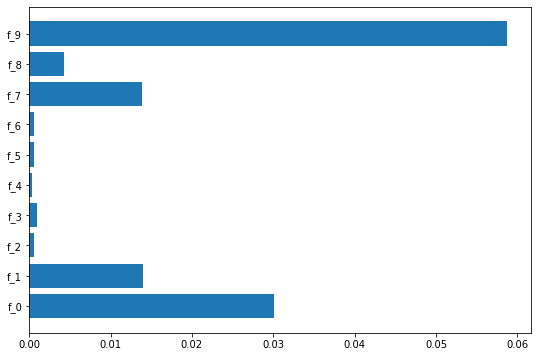

Fidelity  dectree: 0.823529411764706
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.5348837209302325
--- 0.09053850173950195 seconds ---
IF f_0 >=0.5720754265785217 AND f_3 >=-0.47614558041095734 THEN class = 1 # 0.9444444444444444



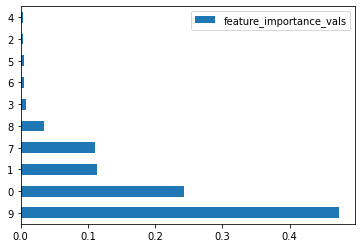

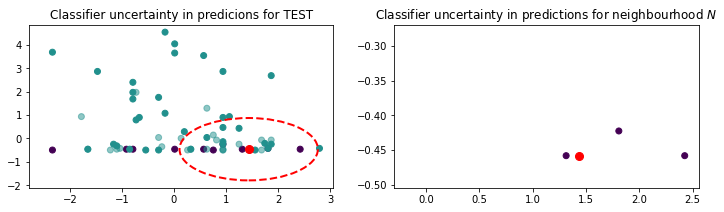

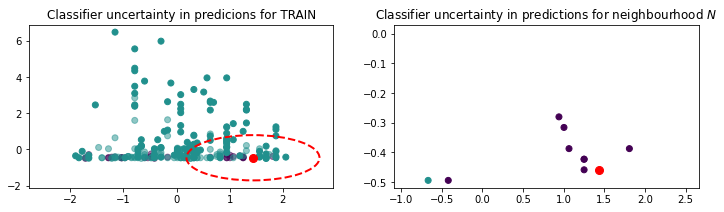

Fidelity  with ablation: 0.6666666666666666
f_0>=0.5720754265785217 and f_3>=-0.47614558041095734
f_0>=0.5720754265785217 and f_3>=-0.47614558041095734
SHAP Ablation coverage: nn: 0.5 and local: 0.3356164383561644
Full rule: {'rule': {'f_0': ['>= 0.5720754265785217'], 'f_3': ['>= -0.47614558041095734']}, 'prediction': '1', 'confidence': 0.9444444444444444}
SHAPGAIN LUX Ablation:0.12518178116456416


Exact explainer: 86it [00:28,  1.91it/s]                        


Done 0.7058823529411765 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 226 (0.517162471395881)
Lux w shap
In fact using: 0.517162471395881 samples from train set wiuth class balance: 0.6283185840707964


Exact explainer: 79it [00:24,  1.98it/s]                        
Exact explainer: 66it [00:17,  1.67it/s]                        
Exact explainer: 149it [00:42,  2.91it/s]                         
Exact explainer: 143it [00:41,  2.83it/s]                         
Exact explainer: 117it [00:32,  2.77it/s]                         
Exact explainer: 115it [00:31,  2.85it/s]                         
Exact explainer: 113it [00:30,  2.84it/s]                         


--- 269.2525887489319 seconds ---
IF f_0 >=0.551354169845581 AND f_9 >=0.596826583147049 AND f_8 <0.9621936082839966 AND f_8 >=-0.29641658812761307 AND f_7 <0.8453569114208221 THEN class = 1 # 1.0



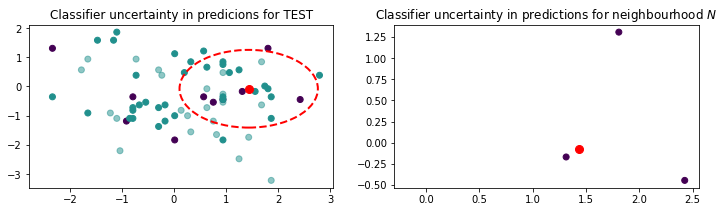

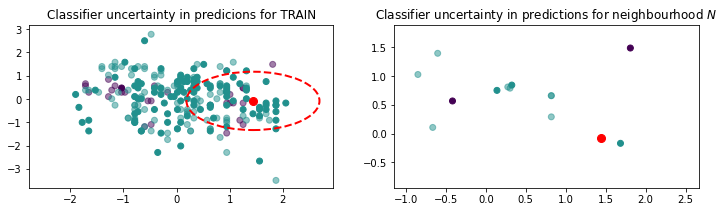

Fidelity  with shap: 0.7142857142857143
f_0>=0.551354169845581 and f_9>=0.596826583147049 and f_8<0.9621936082839966 and f_8>=-0.29641658812761307 and f_7<0.8453569114208221
f_0>=0.551354169845581 and f_9>=0.596826583147049 and f_8<0.9621936082839966 and f_8>=-0.29641658812761307 and f_7<0.8453569114208221
SHAP coverage: nn: 0.14285714285714285 and local: 0.0273972602739726
Full rule: {'rule': {'f_0': ['>= 0.551354169845581'], 'f_9': ['>= 0.596826583147049'], 'f_8': ['>= -0.29641658812761307', '< 0.9621936082839966'], 'f_7': ['< 0.8453569114208221']}, 'prediction': '1', 'confidence': 1.0}
SHAPGAIN LUX:0.2156942586236994
Fidelity  EXPLAN: 0.6666666666666667
LORE expl e = {'f_2': ['<-0.37012283504009247'], 'f_0': ['>=1.0357269644737244'], 'f_1': ['== -1.7622808524230416'], 'f_5': ['<0.4537147134542465'], 'f_9': ['>=0.15989858657121658'], 'f_8': ['>=-0.9333400428295135'], 'f_4': ['>=-0.4949544817209244'], 'f_6': ['<0.12501858174800873'], 'f_7': ['>=-0.399430513381958']}
f_2<-0.37012283504

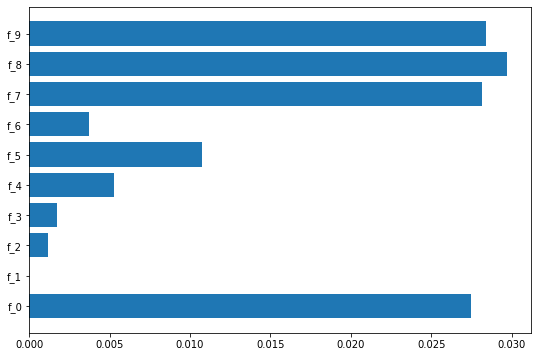

Fidelity  dectree: 0.6153846153846153
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.3488372093023256
--- 0.10253286361694336 seconds ---
IF f_0 <1.004816859960556 AND f_9 <0.5748753696680069 AND f_8 >=-0.11556158028542995 AND f_3 <-0.44050876796245575 AND f_7 >=-0.8143605887889862 THEN class = 0 # 0.9285714285714286



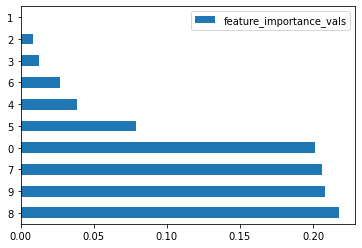

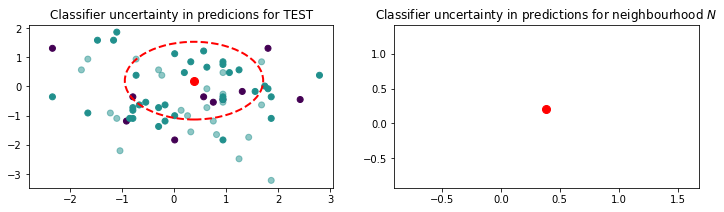

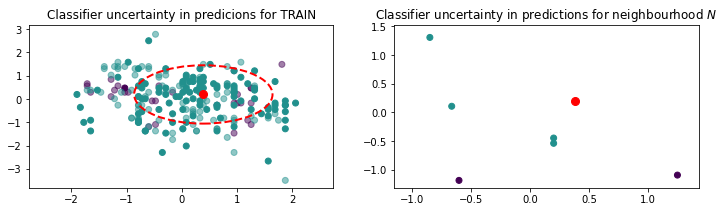

Fidelity  with ablation: 0.6666666666666666
f_0<1.004816859960556 and f_9<0.5748753696680069 and f_8>=-0.11556158028542995 and f_3<-0.44050876796245575 and f_7>=-0.8143605887889862
f_0<1.004816859960556 and f_9<0.5748753696680069 and f_8>=-0.11556158028542995 and f_3<-0.44050876796245575 and f_7>=-0.8143605887889862
SHAP Ablation coverage: nn: 0.2857142857142857 and local: 0.13013698630136986
Full rule: {'rule': {'f_0': ['< 1.004816859960556'], 'f_9': ['< 0.5748753696680069'], 'f_8': ['>= -0.11556158028542995'], 'f_3': ['< -0.44050876796245575'], 'f_7': ['>= -0.8143605887889862']}, 'prediction': '0', 'confidence': 0.9285714285714286}
SHAPGAIN LUX Ablation:0.16931481481481483


Exact explainer: 86it [00:14,  1.82it/s]                        


Done 0.5529411764705883 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 213 (0.4874141876430206)
Lux w shap
In fact using: 0.4874141876430206 samples from train set wiuth class balance: 0.6807511737089202


Exact explainer: 198it [00:37,  4.13it/s]                         
Exact explainer: 186it [00:33,  4.26it/s]                         
Exact explainer: 179it [00:30,  4.29it/s]                         
Exact explainer: 171it [00:30,  4.15it/s]                         
Exact explainer: 167it [00:29,  4.13it/s]                         
Exact explainer: 162it [00:29,  3.99it/s]                         
Exact explainer: 110it [00:15,  1.66it/s]                         
Exact explainer: 105it [00:13,  1.27it/s]                         


--- 251.01486587524414 seconds ---
IF f_0 >=0.11740568652749062 AND f_5 <0.4677586108446121 AND f_9 < 3.0689777527426396 * f_0+1.120649960629987 AND f_9 >=-1.3505945801734924 AND f_8 <0.4741825759410858 AND f_8 >=-0.4256802350282669 AND f_3 >=-0.4618992805480957 THEN class = 1 # 0.9807692307692306



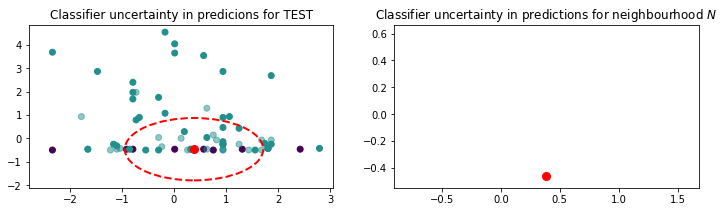

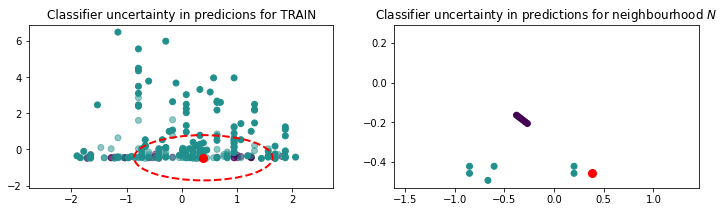

Fidelity  with shap: 0.3333333333333333
f_0>=0.11740568652749062 and f_5<0.4677586108446121 and f_9< 3.0689777527426396 * f_0+1.120649960629987 and f_9>=-1.3505945801734924 and f_8<0.4741825759410858 and f_8>=-0.4256802350282669 and f_3>=-0.4618992805480957
f_0>=0.11740568652749062 and f_5<0.4677586108446121 and f_9< 3.0689777527426396 * f_0+1.120649960629987 and f_9>=-1.3505945801734924 and f_8<0.4741825759410858 and f_8>=-0.4256802350282669 and f_3>=-0.4618992805480957
SHAP coverage: nn: 0.35714285714285715 and local: 0.15753424657534246
Full rule: {'rule': {'f_0': ['>= 0.11740568652749062'], 'f_5': ['< 0.4677586108446121'], 'f_9': ['< 3.0689777527426396 * f_0+1.120649960629987', '>= -1.3505945801734924'], 'f_8': ['< 0.6526321768760681', '>= -0.4256802350282669', '< 0.4741825759410858'], 'f_3': ['>= -0.4618992805480957']}, 'prediction': '1', 'confidence': 0.9807692307692306}
SHAPGAIN LUX:0.14385449735449715
Fidelity  EXPLAN: 0.6153846153846153
LORE expl e = {'f_2': ['>=-0.42283208668

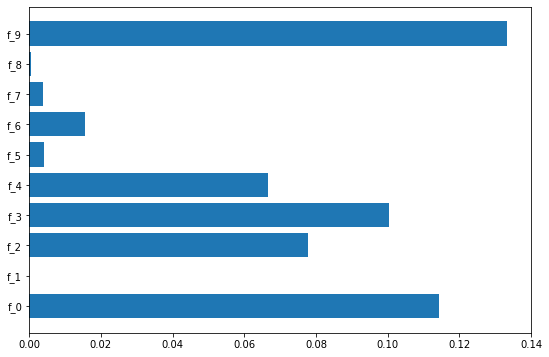

Fidelity  dectree: 0.8421052631578948
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.37209302325581395
--- 0.0959327220916748 seconds ---
IF f_0 <0.9739067554473877 AND f_2 >=-0.39470064640045166 AND f_7 >=0.4304296672344208 THEN class = 0 # 1.0



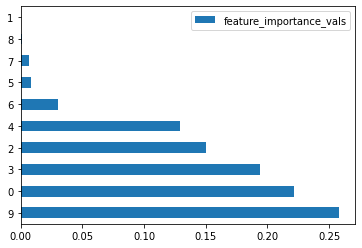

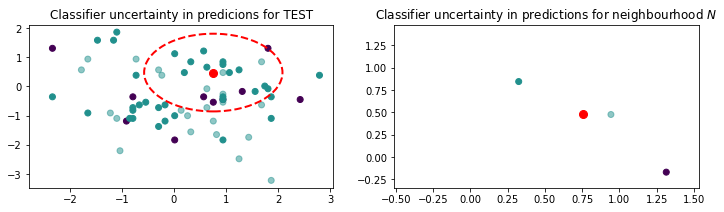

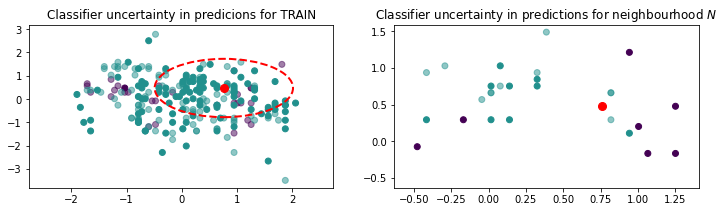

Fidelity  with ablation: 0.8
f_0<0.9739067554473877 and f_2>=-0.39470064640045166 and f_7>=0.4304296672344208
f_0<0.9739067554473877 and f_2>=-0.39470064640045166 and f_7>=0.4304296672344208
SHAP Ablation coverage: nn: 0.2857142857142857 and local: 0.18493150684931506
Full rule: {'rule': {'f_0': ['< 0.9739067554473877'], 'f_2': ['>= -0.39470064640045166'], 'f_7': ['>= -0.030603719875216484', '>= 0.4304296672344208']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.12633160402279978


Exact explainer: 112it [00:21,  2.75it/s]                         


Done 0.8918918918918919 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 321 (0.7345537757437071)
Lux w shap
In fact using: 0.7345537757437071 samples from train set wiuth class balance: 0.37694704049844235


Exact explainer: 262it [00:43,  4.68it/s]                         
Exact explainer: 167it [00:22,  3.52it/s]                         
Exact explainer: 156it [00:19,  2.91it/s]                         
Exact explainer: 96it [00:16,  2.35it/s]                        
Exact explainer: 84it [00:12,  1.48it/s]                        


--- 185.40275287628174 seconds ---
IF f_9 <1.2067711353302002 AND f_9 < 1.1081669733144262 * f_3+1.0584530827547414 AND f_8 <1.4862361550331116 THEN class = 0 # 0.8387096774193548



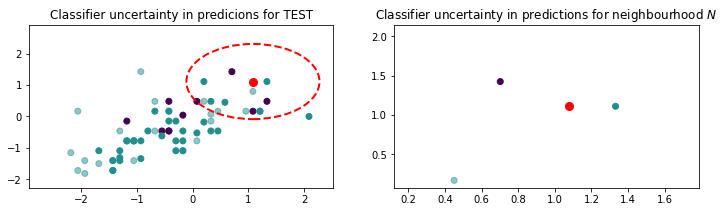

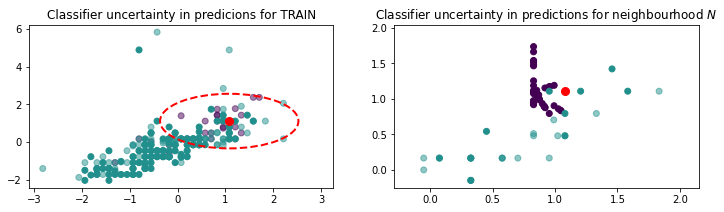

Fidelity  with shap: 0.9473684210526316
f_9<1.2067711353302002 and f_9< 1.1081669733144262 * f_3+1.0584530827547414 and f_8<1.4862361550331116
f_9<1.2067711353302002 and f_9< 1.1081669733144262 * f_3+1.0584530827547414 and f_8<1.4862361550331116
SHAP coverage: nn: 0.42857142857142855 and local: 0.8287671232876712
Full rule: {'rule': {'f_9': ['< 1.1081669733144262 * f_3+1.0584530827547414', '< 1.2067711353302002'], 'f_8': ['< 1.4862361550331116']}, 'prediction': '0', 'confidence': 0.8387096774193548}
SHAPGAIN LUX:0.12969130759616532
Fidelity  EXPLAN: 1.0
LORE expl e = {'f_0': ['>=-0.3861376643180847'], 'f_9': ['<1.1517690420150757'], 'f_4': ['<0.8502129316329956', '>=0.07930785045027733'], 'f_3': ['>=-0.297961562871933'], 'f_6': ['>=-0.3087581545114517']}
f_0>=-0.3861376643180847 and f_9<1.1517690420150757 and f_4<0.8502129316329956 and f_4>=0.07930785045027733 and f_3>=-0.297961562871933 and f_6>=-0.3087581545114517
f_0>=-0.3861376643180847 and f_9<1.1517690420150757 and f_4<0.85021293

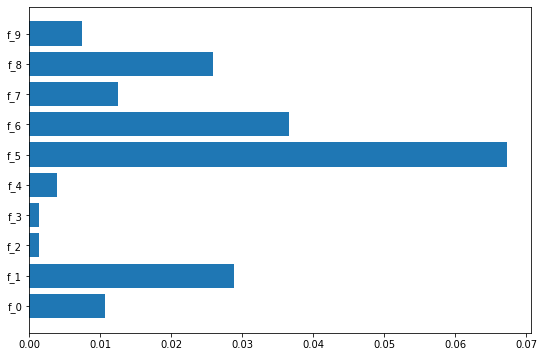

Fidelity  dectree: 0.47058823529411764
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.37209302325581395
--- 0.09138154983520508 seconds ---
IF f_4 >=-0.43289467692375183 AND f_0 <0.04660373646765947 AND f_8 <0.7022168636322021 THEN class = 0 # 1.0



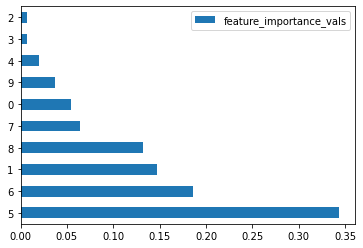

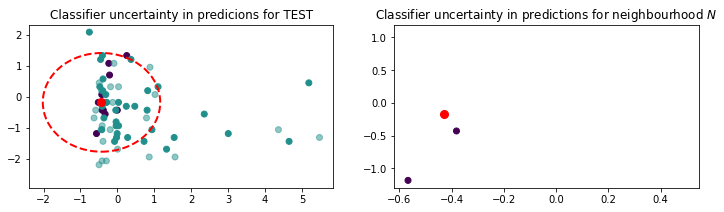

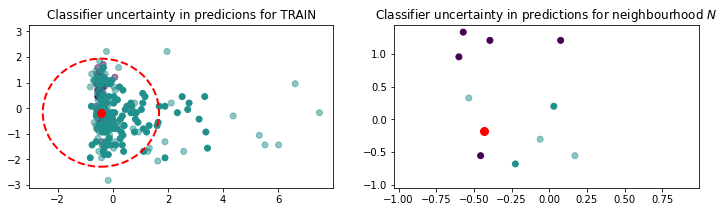

Fidelity  with ablation: 0.588235294117647
f_4>=-0.43289467692375183 and f_0<0.04660373646765947 and f_8<0.7022168636322021
f_4>=-0.43289467692375183 and f_0<0.04660373646765947 and f_8<0.7022168636322021
SHAP Ablation coverage: nn: 0.5714285714285714 and local: 0.2602739726027397
Full rule: {'rule': {'f_4': ['>= -0.43289467692375183'], 'f_0': ['< 0.04660373646765947'], 'f_8': ['< 0.7022168636322021']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.06894899764150932


Exact explainer: 112it [00:42,  2.00it/s]                         


Done 0.6216216216216216 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 291 (0.665903890160183)
Lux w shap
In fact using: 0.665903890160183 samples from train set wiuth class balance: 0.30927835051546393


Exact explainer: 162it [01:05,  2.11it/s]                         
Exact explainer: 109it [00:43,  1.95it/s]                         
Exact explainer: 75it [00:20,  1.90it/s]                        
Exact explainer: 65it [00:15,  1.56it/s]                        
Exact explainer: 54it [00:10,  2.19s/it]                        
Exact explainer: 131it [00:27,  3.68it/s]                         
Exact explainer: 120it [00:26,  3.49it/s]                         
Exact explainer: 118it [00:23,  3.67it/s]                         


--- 309.22451543807983 seconds ---
IF f_0 <-0.0039764270186424255 AND f_5 >=0.3081100136041641 AND f_8 >=-0.4929977059364319 THEN class = 0 # 1.0



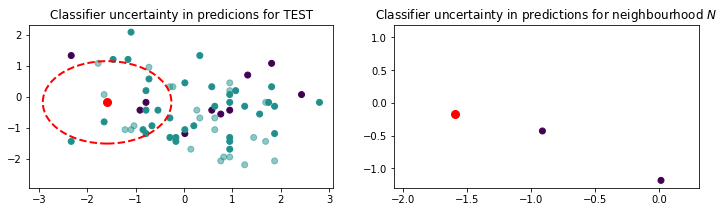

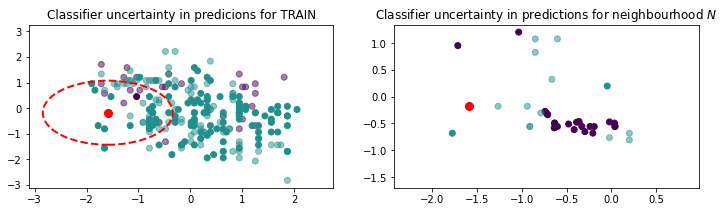

Fidelity  with shap: 0.7999999999999999
f_0<-0.0039764270186424255 and f_5>=0.3081100136041641 and f_8>=-0.4929977059364319
f_0<-0.0039764270186424255 and f_5>=0.3081100136041641 and f_8>=-0.4929977059364319
SHAP coverage: nn: 0.14285714285714285 and local: 0.07534246575342465
Full rule: {'rule': {'f_0': ['< -0.0039764270186424255'], 'f_5': ['>= 0.3081100136041641'], 'f_8': ['>= -0.4929977059364319']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.1768960053066039
Fidelity  EXPLAN: 0.5333333333333333
LORE expl e = {'f_1': ['== -1.7622808524230416'], 'f_5': ['>=0.19886945188045502'], 'f_6': ['>=-0.0828307531774044'], 'f_7': ['<-0.7769012451171875']}
f_1== -1.7622808524230416 and f_5>=0.19886945188045502 and f_6>=-0.0828307531774044 and f_7<-0.7769012451171875
f_1== -1.7622808524230416 and f_5>=0.19886945188045502 and f_6>=-0.0828307531774044 and f_7<-0.7769012451171875
Explan coverage: nn: 0.07142857142857142 and local: 0.0136986301369863
Full rule: {'rule': {'f_1': ['== -1.76228

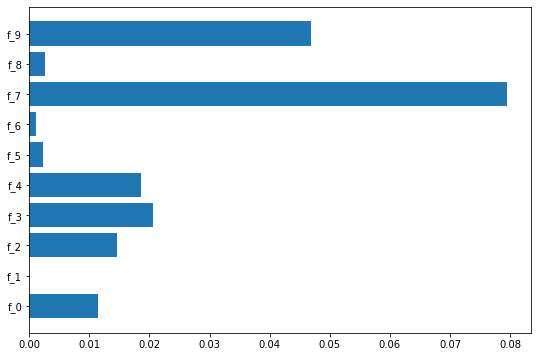

Fidelity  dectree: 0.8421052631578948
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.16279069767441862
--- 0.07153773307800293 seconds ---
IF f_0 >=0.4793451279401779 AND f_9 <-0.6978342831134796 THEN class = 0 # 1.0



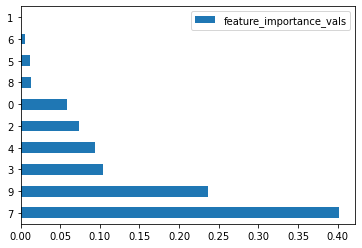

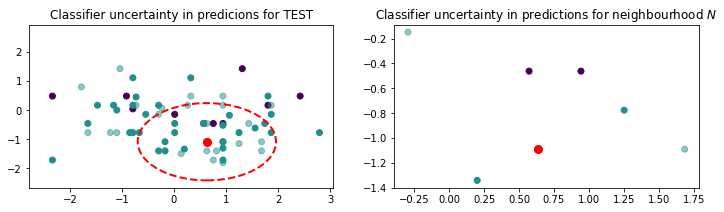

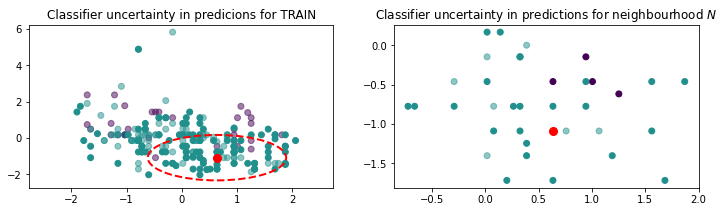

Fidelity  with ablation: 0.9523809523809523
f_0>=0.4793451279401779 and f_9<-0.6978342831134796
f_0>=0.4793451279401779 and f_9<-0.6978342831134796
SHAP Ablation coverage: nn: 0.42857142857142855 and local: 0.14383561643835616
Full rule: {'rule': {'f_0': ['>= 0.4793451279401779'], 'f_9': ['< -0.6978342831134796']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.14735651888461215


Exact explainer: 128it [00:25,  2.99it/s]                         


Done 0.8188976377952756 upsampling
Done 0.952755905511811 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 352 (0.8054919908466819)
Lux w shap
In fact using: 0.8054919908466819 samples from train set wiuth class balance: 0.24431818181818182


Exact explainer: 202it [00:30,  5.06it/s]                         
Exact explainer: 199it [00:27,  5.33it/s]                         
Exact explainer: 152it [00:30,  3.43it/s]                         
Exact explainer: 127it [00:24,  3.05it/s]                         
Exact explainer: 89it [00:15,  2.01it/s]                        
Exact explainer: 81it [00:12,  1.41it/s]                        
Exact explainer: 77it [00:11,  1.05s/it]                        


--- 190.7053143978119 seconds ---
IF f_0 >=-0.1284567043185234 AND f_9 <-0.6623561382293701 THEN class = 0 # 1.0



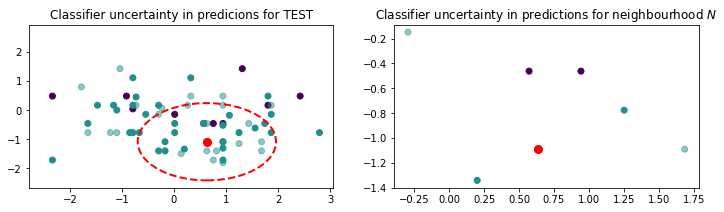

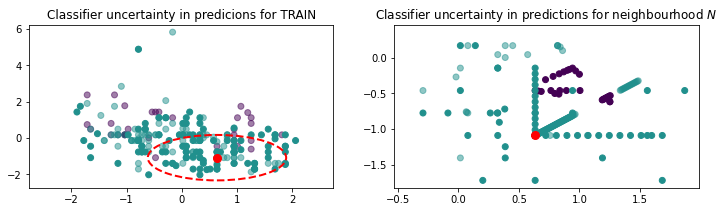

Fidelity  with shap: 0.8421052631578948
f_0>=-0.1284567043185234 and f_9<-0.6623561382293701
f_0>=-0.1284567043185234 and f_9<-0.6623561382293701
SHAP coverage: nn: 0.5 and local: 0.17123287671232876
Full rule: {'rule': {'f_0': ['>= -0.1284567043185234'], 'f_9': ['< -0.6623561382293701']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.14735651888461215
Fidelity  EXPLAN: 0.8000000000000002
LORE expl e = {'f_0': ['>=-0.286988228559494'], 'f_8': ['<0.17094800621271133'], 'f_7': ['>=0.15380945056676865']}
f_0>=-0.286988228559494 and f_8<0.17094800621271133 and f_7>=0.15380945056676865
f_0>=-0.286988228559494 and f_8<0.17094800621271133 and f_7>=0.15380945056676865
Explan coverage: nn: 0.6428571428571429 and local: 0.1095890410958904
Full rule: {'rule': {'f_0': ['>= -0.286988228559494'], 'f_8': ['< 0.17094800621271133'], 'f_7': ['>= 0.15380945056676865']}, 'prediction': '0', 'confidence': 0.9553264604810996}
SHAPGAIN explan:0.15796144657414257
Fidelity  LORE: 0.8333333333333333
LORE 

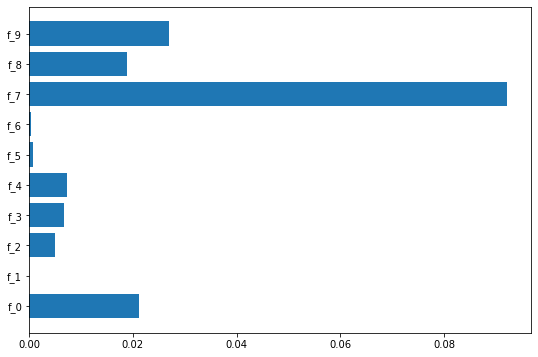

Fidelity  dectree: 0.7999999999999999
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.23255813953488372
--- 0.09276080131530762 seconds ---
IF f_0 >=-0.849789172410965 AND f_5 >=-0.308080792427063 THEN class = 0 # 0.962962962962963



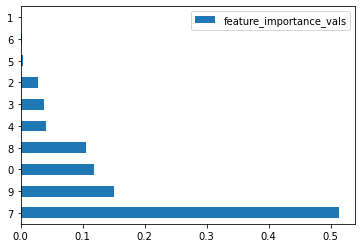

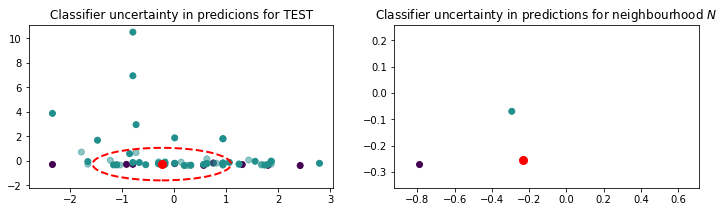

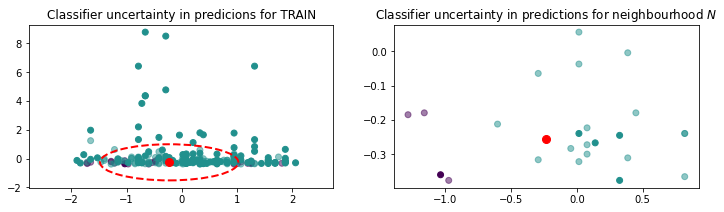

Fidelity  with ablation: 0.782608695652174
f_0>=-0.849789172410965 and f_5>=-0.308080792427063
f_0>=-0.849789172410965 and f_5>=-0.308080792427063
SHAP Ablation coverage: nn: 0.8571428571428571 and local: 0.547945205479452
Full rule: {'rule': {'f_0': ['>= -0.849789172410965'], 'f_5': ['>= -0.308080792427063']}, 'prediction': '0', 'confidence': 0.962962962962963}
SHAPGAIN LUX Ablation:0.06142572824317096


Exact explainer: 120it [00:23,  2.83it/s]                         


Done 0.6890756302521008 upsampling
Done 0.9327731092436975 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 312 (0.7139588100686499)
Lux w shap
In fact using: 0.7139588100686499 samples from train set wiuth class balance: 0.3108974358974359


Exact explainer: 112it [00:23,  2.83it/s]                         
Exact explainer: 101it [00:21,  2.56it/s]                         
Exact explainer: 94it [00:18,  2.41it/s]                        
Exact explainer: 87it [00:15,  2.08it/s]                        
Exact explainer: 70it [00:10, 10.12s/it]                
Exact explainer: 202it [00:33,  4.34it/s]                         
Exact explainer: 180it [00:26,  4.40it/s]                         
Exact explainer: 147it [00:19,  4.21it/s]                         


--- 203.10738372802734 seconds ---
IF f_0 <-0.01521646324545145 AND f_0 >=-0.5362724363803864 AND f_7 >=-0.13411957770586014 THEN class = 0 # 1.0



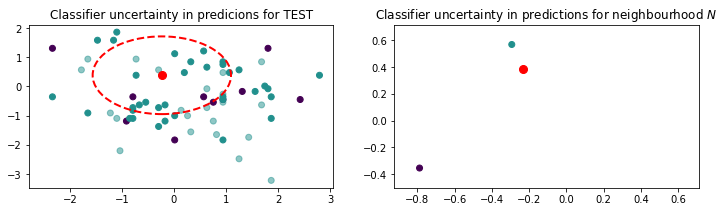

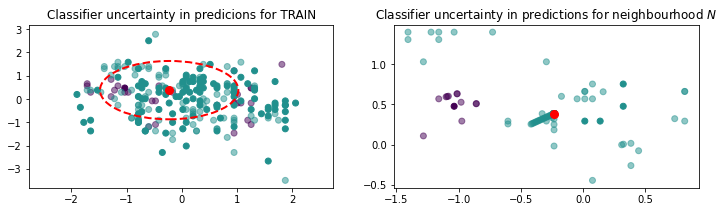

Fidelity  with shap: 0.8888888888888888
f_0<-0.01521646324545145 and f_0>=-0.5362724363803864 and f_7>=-0.13411957770586014
f_0<-0.01521646324545145 and f_0>=-0.5362724363803864 and f_7>=-0.13411957770586014
SHAP coverage: nn: 0.35714285714285715 and local: 0.0821917808219178
Full rule: {'rule': {'f_0': ['>= -0.5362724363803864', '< -0.01521646324545145'], 'f_7': ['>= -0.13411957770586014']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.3163309410369307
Fidelity  EXPLAN: 0.7058823529411765
LORE expl e = {'f_0': ['>=-0.5996606051921844'], 'f_9': ['<0.5748753696680069', '>=-1.0906459093093872'], 'f_8': ['>=-0.618809849023819'], 'f_7': ['<0.7070496380329132', '>=-0.030603719875216484']}
f_0>=-0.5996606051921844 and f_9<0.5748753696680069 and f_9>=-1.0906459093093872 and f_8>=-0.618809849023819 and f_7<0.7070496380329132 and f_7>=-0.030603719875216484
f_0>=-0.5996606051921844 and f_9<0.5748753696680069 and f_9>=-1.0906459093093872 and f_8>=-0.618809849023819 and f_7<0.7070496380329

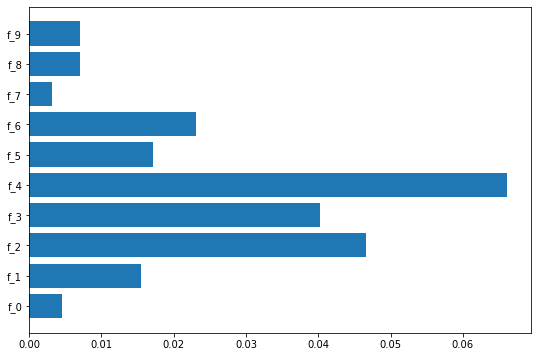

Fidelity  dectree: 1.0
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.0
--- 0.04446578025817871 seconds ---
IF  THEN class = 0 # 1.0

Fidelity  with ablation: 1.0
SHAP Ablation coverage: nn: 1 and local: 1
Full rule: {'rule': {}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:nan


Exact explainer: 172it [01:08,  2.14it/s]                         


Done 0.9005847953216374 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 496 (1.1350114416475972)
Lux w shap
In fact using: 1.1350114416475972 samples from train set wiuth class balance: 0.08870967741935484


Exact explainer: 150it [01:02,  2.03it/s]                         
Exact explainer: 128it [00:50,  2.00it/s]                         
Exact explainer: 121it [00:47,  1.96it/s]                         
Exact explainer: 118it [00:47,  1.93it/s]                         
Exact explainer: 348it [01:55,  2.79it/s]                         


--- 403.0125653743744 seconds ---
IF f_3 >=0.3652936965227127 THEN class = 0 # 1.0



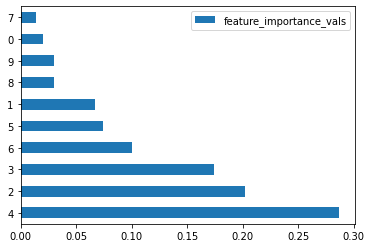

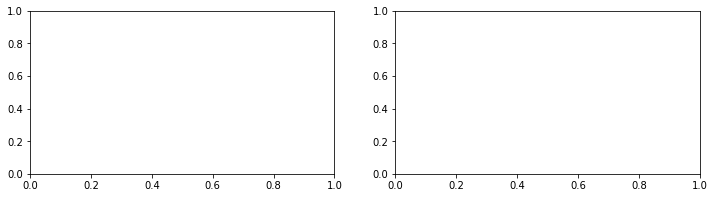

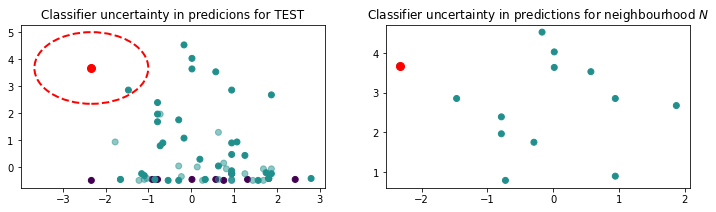

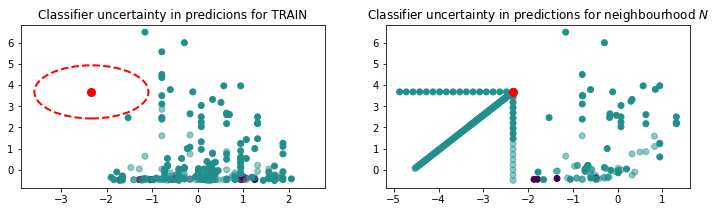

Fidelity  with shap: 1.0
f_3>=0.3652936965227127
f_3>=0.3652936965227127
SHAP coverage: nn: 1.0 and local: 0.15753424657534246
Full rule: {'rule': {'f_3': ['>= 0.3652936965227127']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.17430467514986445
Fidelity  EXPLAN: 1.0
LORE expl e = {'f_4': ['>=1.2606228590011597']}
f_4>=1.2606228590011597
f_4>=1.2606228590011597
Explan coverage: nn: 0.2857142857142857 and local: 0.07534246575342465
Full rule: {'rule': {'f_4': ['>= 0.16615118086338043', '>= 1.2606228590011597']}, 'prediction': '0', 'confidence': 0.9968152866242038}
SHAPGAIN explan:0.2871687718144968
Fidelity  LORE: 1.0
LORE expl e = {'f_6': ['>=0.001469641923904419'], 'f_5': ['>=-0.308080792427063']}
Ats lore: ['f_6', 'f_5']
f_6>=0.001469641923904419 and f_5>=-0.308080792427063
f_6>=0.001469641923904419 and f_5>=-0.308080792427063
LORE coverage: nn: 0.5 and local: 0.17123287671232876
Full rule: {'rule': {'f_6': ['>= 0.001469641923904419'], 'f_5': ['>= -0.308080792427063']}, 'pred

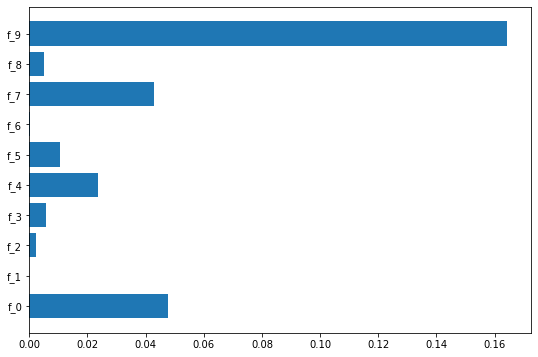

Fidelity  dectree: 0.4444444444444445
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.32558139534883723
--- 0.090667724609375 seconds ---
IF f_0 <0.6029855310916901 AND f_0 >=0.17024414334446192 AND f_9 >=0.6534378230571747 THEN class = 0 # 1.0



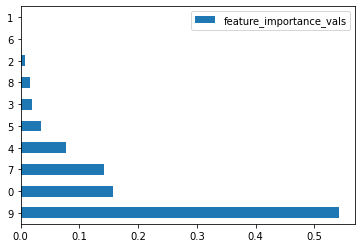

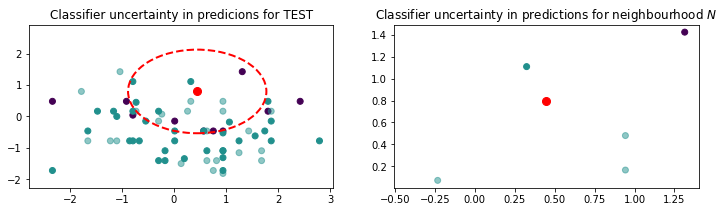

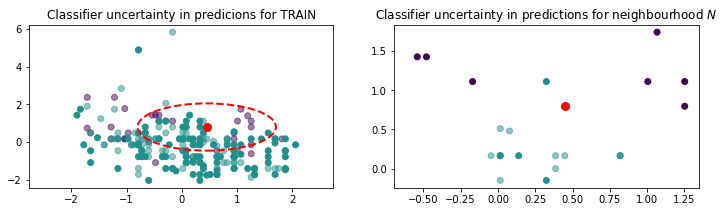

Fidelity  with ablation: 0.4444444444444445
f_0<0.6029855310916901 and f_0>=0.17024414334446192 and f_9>=0.6534378230571747
f_0<0.6029855310916901 and f_0>=0.17024414334446192 and f_9>=0.6534378230571747
SHAP Ablation coverage: nn: 0.21428571428571427 and local: 0.03424657534246575
Full rule: {'rule': {'f_0': ['< 0.6029855310916901', '>= 0.17024414334446192'], 'f_9': ['>= 0.6534378230571747']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.35004046125834504


Exact explainer: 86it [00:13,  1.72it/s]                        


Done 0.5764705882352941 upsampling
Done 0.9529411764705882 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 215 (0.4919908466819222)
Lux w shap
In fact using: 0.4919908466819222 samples from train set wiuth class balance: 0.5162790697674419


Exact explainer: 106it [00:21,  2.71it/s]                         


--- 98.64103698730469 seconds ---
IF f_9 >=0.7508321106433868 AND f_5 >= -21.98085993233942 * f_8+9.90143940998231 AND f_4 <-0.07060874812304974 AND f_7 <0.22224577516317368 AND f_7 < 0.6958377926821568 * f_0+0.5544396602672872 AND f_7 >=0.061602866277098656 THEN class = 1 # 0.9863013698630138



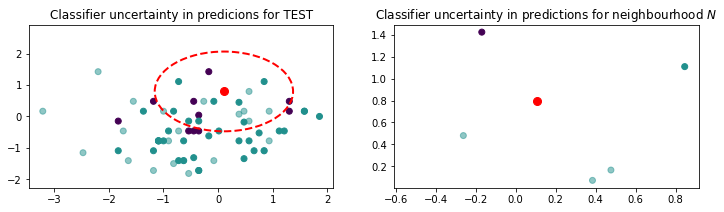

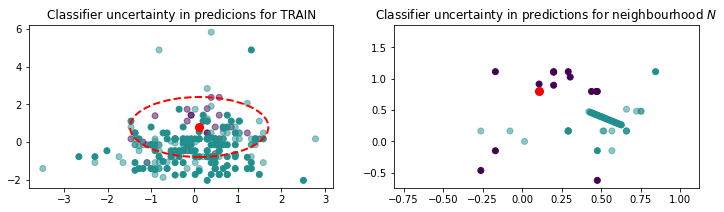

Fidelity  with shap: 0.9090909090909091
f_9>=0.7508321106433868 and f_5>= -21.98085993233942 * f_8+9.90143940998231 and f_4<-0.07060874812304974 and f_7<0.22224577516317368 and f_7< 0.6958377926821568 * f_0+0.5544396602672872 and f_7>=0.061602866277098656
f_9>=0.7508321106433868 and f_5>= -21.98085993233942 * f_8+9.90143940998231 and f_4<-0.07060874812304974 and f_7<0.22224577516317368 and f_7< 0.6958377926821568 * f_0+0.5544396602672872 and f_7>=0.061602866277098656
SHAP coverage: nn: 0.07142857142857142 and local: 0.00684931506849315
Full rule: {'rule': {'f_9': ['>= 0.7508321106433868'], 'f_5': ['>= -21.98085993233942 * f_8+9.90143940998231'], 'f_4': ['< -0.07060874812304974'], 'f_7': ['< 0.6958377926821568 * f_0+0.5544396602672872', '>= 0.061602866277098656', '< 0.22224577516317368']}, 'prediction': '1', 'confidence': 0.9863013698630138}
SHAPGAIN LUX:0.19926425961847438
Fidelity  EXPLAN: 0.9090909090909091
LORE expl e = {'f_0': ['>=-0.23214825242757797'], 'f_9': ['>=0.48731197416782

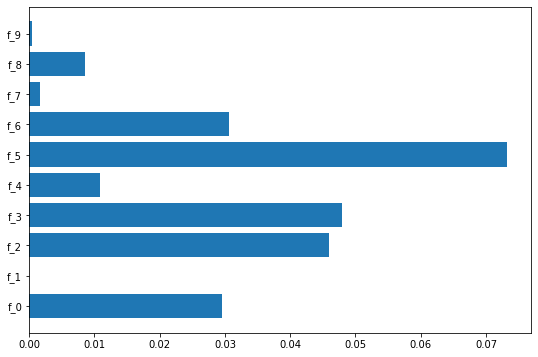

Fidelity  dectree: 0.6153846153846153
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.32558139534883723
--- 0.09660029411315918 seconds ---
IF f_5 >=-0.14640477299690247 THEN class = 0 # 1.0



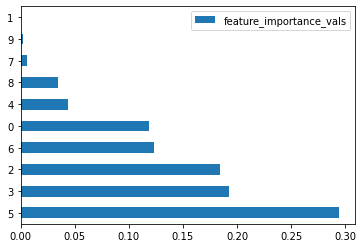

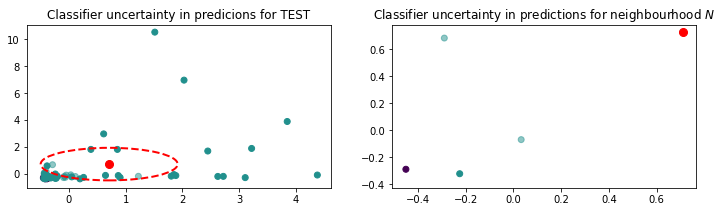

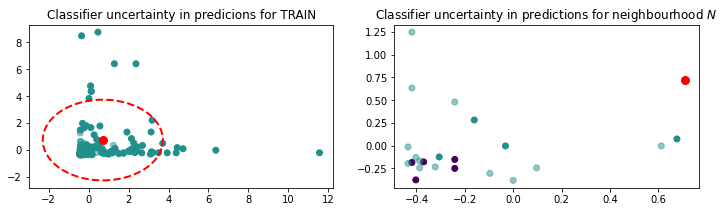

Fidelity  with ablation: 0.7058823529411764
f_5>=-0.14640477299690247
f_5>=-0.14640477299690247
SHAP Ablation coverage: nn: 0.2857142857142857 and local: 0.273972602739726
Full rule: {'rule': {'f_5': ['>= -0.14640477299690247']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.29467730239303797


Exact explainer: 116it [00:21,  2.84it/s]                         


Done 0.9130434782608695 upsampling
Done 0.9652173913043478 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 331 (0.7574370709382151)
Lux w shap
In fact using: 0.7574370709382151 samples from train set wiuth class balance: 0.338368580060423


Exact explainer: 161it [00:30,  3.58it/s]                         
Exact explainer: 121it [00:23,  3.00it/s]                         
Exact explainer: 113it [00:21,  2.89it/s]                         
Exact explainer: 111it [00:21,  2.82it/s]                         
Exact explainer: 104it [00:19,  2.68it/s]                         
Exact explainer: 172it [00:25,  5.01it/s]                         
Exact explainer: 169it [00:28,  4.39it/s]                         


--- 203.46379256248474 seconds ---
IF f_4 <0.32833413779735565 AND f_6 >=-0.029919542372226715 THEN class = 0 # 1.0



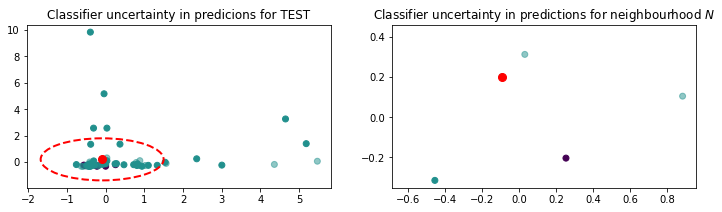

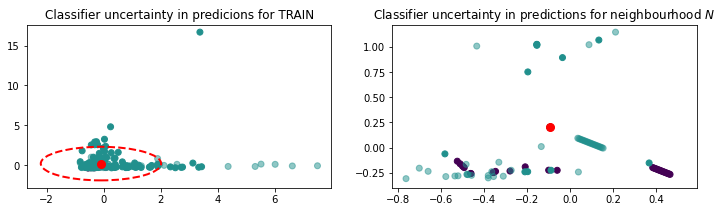

Fidelity  with shap: 0.625
f_4<0.32833413779735565 and f_6>=-0.029919542372226715
f_4<0.32833413779735565 and f_6>=-0.029919542372226715
SHAP coverage: nn: 0.21428571428571427 and local: 0.136986301369863
Full rule: {'rule': {'f_4': ['< 0.32833413779735565'], 'f_6': ['>= -0.029919542372226715']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX:0.08326323422770106
Fidelity  EXPLAN: 0.7272727272727272
LORE expl e = {'f_2': ['>=0.027731807436794043'], 'f_0': ['<-0.17862865328788757'], 'f_9': ['>=0.473459929227829'], 'f_5': ['>=-0.217651829123497']}
f_2>=0.027731807436794043 and f_0<-0.17862865328788757 and f_9>=0.473459929227829 and f_5>=-0.217651829123497
f_2>=0.027731807436794043 and f_0<-0.17862865328788757 and f_9>=0.473459929227829 and f_5>=-0.217651829123497
Explan coverage: nn: 0.14285714285714285 and local: 0.02054794520547945
Full rule: {'rule': {'f_2': ['>= 0.027731807436794043'], 'f_0': ['< -0.17862865328788757'], 'f_9': ['>= 0.473459929227829'], 'f_5': ['>= -0.2176518291234

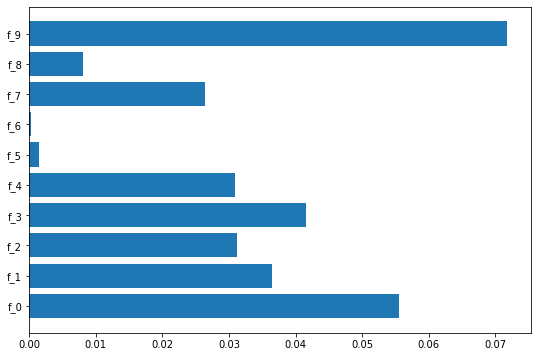

Fidelity  dectree: 0.5
Lux w Ablation
In fact using: 0.09839816933638444 samples from train set wiuth class balance: 0.3953488372093023
--- 0.08925366401672363 seconds ---
IF f_2 >=-0.2818737328052521 THEN class = 0 # 1.0



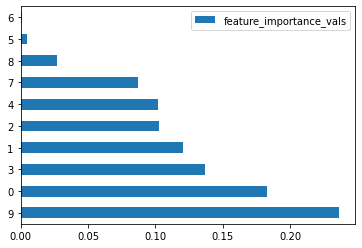

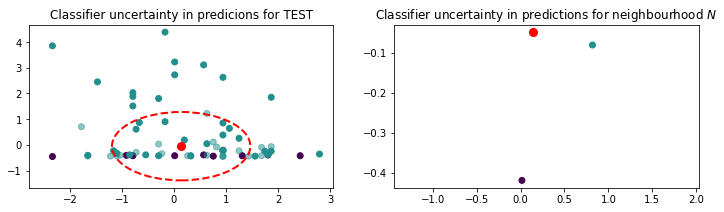

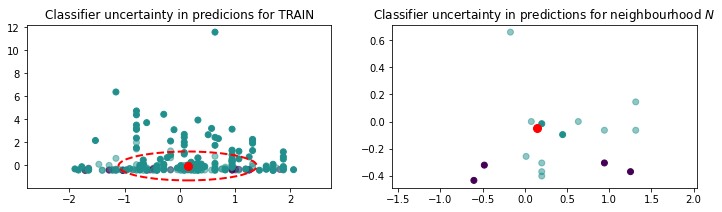

Fidelity  with ablation: 0.5454545454545454
f_2>=-0.2818737328052521
f_2>=-0.2818737328052521
SHAP Ablation coverage: nn: 0.2857142857142857 and local: 0.363013698630137
Full rule: {'rule': {'f_2': ['>= -0.2818737328052521']}, 'prediction': '0', 'confidence': 1.0}
SHAPGAIN LUX Ablation:0.10260019480673815


Exact explainer: 112it [00:40,  2.08it/s]                         


Done 0.8018018018018018 upsampling
Done 1.0 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')
Train sample size: 311 (0.7116704805491991)
Lux w shap
In fact using: 0.7116704805491991 samples from train set wiuth class balance: 0.33762057877813506


Exact explainer: 111it [00:37,  2.16it/s]                         
Exact explainer: 202it [01:00,  2.87it/s]                         
Exact explainer: 181it [00:50,  3.07it/s]                         
Exact explainer:  75%|███████▌  | 126/168 [00:31<00:09,  4.37it/s]

In [ ]:
import time
import traceback
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
hits = []
confidences =[]
times=[]
rules = []
rule_coverages = []
rule_coverages_nn = []
rule_local_fid_data_nn = []
rule_local_fid_data = []
explanation_length = []

rs=42
init_fraction=0.1
data_prefix = './results/ablation-full-knn/'
directory = './data/num_and_cat/balanced'
up=False
#depth = 2
SAMPLE_SIZE=50
show=False
ismpl=False
oblique=False
synthetic = False
density_sampling=False#True
radius_sampling=False#True
oversampling=False
ostr ='both'
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
node_size_limit = 2
n_jobs=-1
n_jobs_uid3=None
min_generate_samples=0.3

importance_gain_ablation=0
ats_ablation=[]
lux_conf_ablation=0
cov_ablation_nn=acc_ablation_nn=prec_ablation_nn=rec_ablation_nn=f1_ablation_nn =cov_ablation=acc_ablation=prec_ablation=rec_ablation=f1_ablation =0
time_lux_ablation=ac_score_ablation=prec_score_ablation=rec_score_ablation=f1_score_ablation=ac_score_ablation_acc=hit_lux_ablation=0
ablation_lux_elen=0
rule_lux_ablation={}

importance_gain_shap=0
ats_shap=[]
lux_conf_shap=0
cov_shap_nn=acc_shap_nn=prec_shap_nn=rec_shap_nn=f1_shap_nn =cov_shap=acc_shap=prec_shap=rec_shap=f1_shap =0
time_lux_shap=ac_score_shap=prec_score_shap=rec_score_shap=f1_score_shap=ac_score_shap_acc=hit_lux_shap=0
shap_lux_elen=0
rule_lux_shap={}

importance_gain_noproba=0
ats_no_proba=[]
lux_conf_pure=0
cov_pure= acc_pure= prec_pure= rec_pure=f1_pure  =0
cov_pure_nn= acc_pure_nn= prec_pure_nn= rec_pure_nn=f1_pure_nn  =0
time_lux_pure=ac_score_pure=prec_score_pure=rec_score_pure=f1_score_pure=ac_score_pure_acc=hit_lux_pure=0
pure_lux_elen=0
rule_lux_pure={}

importance_gain_with_proba=0
ats_with_proba=[]
lux_conf_proba=0
cov_proba= acc_proba= prec_proba= rec_proba=f1_proba  =0
cov_proba_nn= acc_proba_nn= prec_proba_nn= rec_proba_nn=f1_proba_nn  =0
time_lux_proba=ac_score_proba=prec_score_proba=rec_score_proba=f1_score_proba=ac_score_proba_acc=hit_lux_proba=0
proba_lux_elen=0
rule_lux_proba={}

UId3.PARALLEL_ENTRY_FACTOR = 1000
nf = 4
SYNTH_BREAK=12
progress = []

skip=True
ds = list(pd.read_csv(f'{data_prefix}synthx100_local_fid.csv')['dataset'].unique())
dsred = list(pd.read_csv(f'./results/ablation-full-mlp/synthx100_local_fid.csv')['dataset'].unique())
missing = [d for d in dsred if d not in ds]

for task_id in tasks:

    if use_suite:
        task = openml.tasks.get_task(task_id)
        num_and_cat = task.get_dataset().name
    else:
        num_and_cat= classification_datasets[classification_datasets['did'] == task_id]['name'].values[0]
        

    if num_and_cat not in missing and skip:
        continue
    if num_and_cat in  ['','FOREX_eurpln-day-Close','satimage','GesturePhaseSegmentationProcessed']: 
        continue
    print('Processing '+num_and_cat)
    
    try:
        rules_temp = []
        clf_basic  =KNeighborsClassifier()#RandomForestClassifier()#GradientBoostingClassifier()#MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
        clf = clf_basic
        
        if use_suite:
            split = task.get_train_test_split_indices()
            data,y= task.get_X_and_y()
            Xtrain = data[split.train]
            ytrain = y[split.train]
            
            Xtest= data[split.test]
            ytest = y[split.test]
            features = [f'f_{i}' for i in range(0,data.shape[1])]
            categorical_indicator=[False]*len(features)
        else:
            dataset = openml.datasets.get_dataset(task_id)
            X, y, categorical_indicator, features = dataset.get_data(target=dataset.default_target_attribute)
            features = [re.sub(r'[^\w]', '_', s) for s in features]
            X.columns=features
            le = LabelEncoder ()
            y = le.fit_transform(y)
            for col, is_categorical in zip(X.columns, categorical_indicator):
                if is_categorical:
                    # Apply LabelEncoder to the column
                    X[col] = le.fit_transform(X[col])

            if 'Timestamp' in X.columns:
                continue
                
            Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.33)
            data=X
            if sum(categorical_indicator) > 0 :
                continue
    
        
            
        target = 'class'
        
        if synthetic: 
            if nf > SYNTH_BREAK:
                break
            #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
            X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                                  n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                                  n_classes=2)
            features = [f'f_{i}' for i in range(0,X.shape[1])]
            categorical_indicator=[False]*len(features)
            df = pd.DataFrame(X, columns=features)
            df[target] = y
            num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
            directory='synthetic'
        else:
            continuous_indicator = np.logical_not(categorical_indicator)
            df = pd.DataFrame(data,columns=features,dtype=float)
            if sum(continuous_indicator) > 0:
                sc = StandardScaler()
                df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
            df[target] = y
        
        nf+=1
        depth = len(features)
    
        missing_percentages = df.isnull().mean() * 100
    
        # Filter columns where missing values exceed 75%
        columns_to_keep = missing_percentages[missing_percentages <= 75].index
        
        # Select only the columns to keep
        df_filtered = df[columns_to_keep]
    
        features = [f for f in features if f in df_filtered.columns]
        
        df =df.dropna()
    except:
        print('Skipping due to problems in loading a dataset')
        continue

    if df.shape[1] > 50:
        print(f'Large fsize: skip: {num_and_cat}')
        continue
    if (len(df) >10000):
        print('Large'+num_and_cat+' size: '+str(len(df)))
        continue
        df = df.sample(1000)
        fraction = init_fraction
    else:
        fraction = init_fraction
        
    print(num_and_cat)
    if df[target].nunique() > 2:
        average="micro"
    else:
        average="binary"

    progress.append(num_and_cat)
    num+=1
    
    if len(df) < 100:
        print(f'error: {num_and_cat}')
        continue

    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    print(f'Train size: {len(train)}')
    
    processed_samples = 0
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)  
         
        with open(f'./results/progress.txt', 'w') as fp:
            fp.write('\n'.join(progress))
            fp.write(f'Processed {processed_samples}/100')
        processed_samples +=1
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        nn.fit(train[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh_tr= train.iloc[ids_c.ravel()]
        
        try:
            up=False
            #depth = 2
            show=False
            ismpl=False
            oblique=False
            synthetic = False
            density_sampling=False#True
            radius_sampling=False#True
            oversampling=False
            ostr ='both'
            uncertain_entropy_evaluator=UncertainEntropyEvaluator()
            representative=LUX.REPRESENTATIVE_NEAREST
            node_size_limit = 2
            n_jobs=-1
            n_jobs_uid3=None
            min_generate_samples=0.3
            start_time = time.time()
            ##############for testing dectree on the bbox sample################
            lux = LUX(predict_proba = clf.predict_proba, classifier=None,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
                      oversampling_strategy=ostr,
                      node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
            X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                      X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                      use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                     representative=representative,density_sampling=density_sampling,n_jobs=-1)
            print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
            ###################################################################
            time_lux_gen = time.time() - start_time
            #shap on this sample
            #append pint as a first element and plot force plot
            X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        except:
            print('Skipping, due to problems in creating dataset for ablation model')
            traceback.print_exc()  # This prints the full traceback
            continue
            
    
            
        try:
            explainer = shap.Explainer(clf,X_shap)
            if hasattr(explainer, "shap_values"):
                shap_values = explainer.shap_values(X_shap,check_additivity=False)
            else:
                shap_values = explainer(X_shap).values
                shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            if hasattr(explainer, "expected_value"):
                expected_values = explainer.expected_value
            else:
                expected_values=[np.mean(v) for v in shap_values]
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values = explainer(X_shap).values
            shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            expected_values=[np.mean(v) for v in shap_values]


        if type(shap_values) is not list:
            shap_values = [-shap_values, shap_values]
            expected_values=[np.mean(v) for v in shap_values]

        
        plt.figure(figsize=(9,6))
        plt.barh(features ,np.abs(shap_values).mean(0)[0])
        plt.show()
        vals = np.abs(shap_values).mean(0)[0]/np.abs(shap_values).mean(0)[0].sum()
        rsv = [sv[1:] for sv in shap_values]
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator+[True])
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))
        feature_importance.plot(kind='barh')
        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))
            
        pos_label = clf.predict(explain_instance)[0]

        dectree_score =  accuracy_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]))
        dectree_score_prec =  precision_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_rec =  recall_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_f1 =  f1_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        print(f'Fidelity  dectree: {dectree_score_f1}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        
        
        nodes = np.where(1==clf_dtree.decision_path(explain_instance).todense())[1]
        features_idxs = clf_dtree.tree_.feature[nodes][:-1]
        dtree_ats = list(set(([features[i] for i in features_idxs])))
        dtree_elen = len(dtree_ats)
        
        importance_gain_dtree = shapfeatures[shapfeatures['col_name'].isin(dtree_ats)]['feature_importance_vals'].sum()/len(dtree_ats)
        
        hit_dectree = (clf_dtree.predict(explain_instance)==clf.predict(explain_instance))


        
        
       
        ########################################################## ###### #######################################################
        ########################################################## Ablation #######################################################

        try:
            print('Lux w Ablation')
            start_time = time.time()
            lux.attributes_names=X_train_sample.columns
           
            
            y_train_sample_proba = lux.predict_proba(X_train_sample)
            hot = np.argmax(y_train_sample_proba,axis=1)
            y_train_sample = np.zeros(y_train_sample_proba.shape)
            for i in range(0,len(y_train_sample)):
                y_train_sample[i,hot[i]] = 1
            #limit features here

            
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, 
                                        classifier=lux.classifier, 
                                        discount_importance=False, depth=0,beta=1,n_jobs=n_jobs_uid3,prune=True,oblique=oblique,imp=None)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1, n_jobs=n_jobs_uid3,prune=True,oblique=oblique,imp=None)


            try:
                time_lux_ablation = time.time() - start_time+time_lux_gen
                print("--- %s seconds ---" % (time_lux_ablation))
    
                if show:
                    lux.uid3.tree.save_dot('tree.dot')
                    gvz=graphviz.Source.from_file('tree.dot')
                    display(gvz)
                f1,f2=get_plot_features(lux,explain_instance,all_features = features)
                plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
                plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
                #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
            except:
                print('WARNING: Degenerated explantion, failed to get rule')


            predictions = [int(eval(x.get_name())) for x in lux.uid3.predict(data.instances)]
            ac_score_ablation = accuracy_score(clf.predict(dfneigh[features]),predictions)
            prec_score_ablation = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_ablation = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_ablation = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            hit_lux_ablation = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])
            print(f'Fidelity  with ablation: {f1_score_ablation}')
            ac_score_ablation_acc = accuracy_score(dfneigh[target],predictions)

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_ablation = justification_dict['rule']
            ablation_lux_elen = len(justification_dict['rule'].keys())


            cov_ablation, acc_ablation, prec_ablation, rec_ablation, f1_ablation = coverage_precision(rule_lux_ablation, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_ablation_nn, acc_ablation_nn, prec_ablation_nn, rec_ablation_nn, f1_ablation_nn = coverage_precision(rule_lux_ablation, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            print(f'SHAP Ablation coverage: nn: {cov_ablation_nn} and local: {cov_ablation}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')

            justification = lux.justify(explain_instance)[0]
            lux_conf_ablation = justification.split("#")[1]
            ats_ablation= list(justification_dict['rule'].keys())
            importance_gain_ablation = shapfeatures[shapfeatures['col_name'].isin(ats_ablation)]['feature_importance_vals'].sum()/len(ats_ablation)
            print(f'SHAPGAIN LUX Ablation:{importance_gain_ablation}')
        except:
            importance_gain_ablation=0
            ats_ablation=[]
            lux_conf_ablation=0
            cov_ablation_nn=acc_ablation_nn=prec_ablation_nn=rec_ablation_nn=f1_ablation_nn =cov_ablation=acc_ablation=prec_ablation=rec_ablation=f1_ablation =0
            time_lux_ablation=ac_score_ablation=prec_score_ablation=rec_score_ablation=f1_score_ablation=ac_score_ablation_acc=hit_lux_ablation=0
            ablation_lux_elen=0
            rule_lux_ablation={}


        try:    
            up=True
            #depth = 2
            show=False
            ismpl=True
            oblique=True
            synthetic = False
            density_sampling=False#True
            radius_sampling=False#True
            oversampling=True
            ostr ='both'
            uncertain_entropy_evaluator=UncertainEntropyEvaluator()
            representative=LUX.REPRESENTATIVE_NEAREST
            node_size_limit = 2
            n_jobs=-1
            n_jobs_uid3=None
            min_generate_samples=0.3

            start_time = time.time()
            ##############for testing dectree on the bbox sample################
            lux = LUX(predict_proba = clf.predict_proba, 
                      classifier=clf,
                      neighborhood_size=fraction,max_depth=depth,  min_samples=5,
                      oversampling_strategy=ostr,
                      node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
            X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                      X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                      use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                     representative=representative,density_sampling=density_sampling,n_jobs=-1)
            print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
            ###################################################################
            time_lux_gen = time.time() - start_time
            #shap on this sample
            #append pint as a first element and plot force plot
            X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        except:
            print('Skipping, due to problems in creating dataset for SHAP model')
            traceback.print_exc()  # This prints the full traceback
            continue


        ########################################################## ###### #######################################################
        ########################################################## LUSX + SHAP #######################################################
        try:

            print('Lux w shap')
            start_time = time.time()
            lux.attributes_names=X_train_sample.columns
           
            
            y_train_sample_proba = lux.predict_proba(X_train_sample)
            hot = np.argmax(y_train_sample_proba,axis=1)
            y_train_sample = np.zeros(y_train_sample_proba.shape)
            for i in range(0,len(y_train_sample)):
                y_train_sample[i,hot[i]] = 1
            #limit features here

            
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, 
                                        classifier=lux.classifier, #what if not using it here, just for sampling
                                        discount_importance=False, depth=0,beta=1,n_jobs=n_jobs_uid3,prune=True,oblique=oblique,imp=rsv)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1, n_jobs=n_jobs_uid3,prune=True,oblique=oblique,imp=rsv)


            try:
                time_lux_shap = time.time() - start_time+time_lux_gen
                print("--- %s seconds ---" % (time_lux_shap))
    
                if show:
                    lux.uid3.tree.save_dot('tree.dot')
                    gvz=graphviz.Source.from_file('tree.dot')
                    display(gvz)
                f1,f2=get_plot_features(lux,explain_instance,all_features = features)
                plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
                plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
                #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
            except:
                print('WARNING: Degenerated explantion, failed to get rule')


            predictions = [int(eval(x.get_name())) for x in lux.uid3.predict(data.instances)]
            ac_score_shap = accuracy_score(clf.predict(dfneigh[features]),predictions)
            prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            hit_lux_shap = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])
            print(f'Fidelity  with shap: {f1_score_shap}')
            ac_score_shap_acc = accuracy_score(dfneigh[target],predictions)

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_shap = justification_dict['rule']
            shap_lux_elen = len(justification_dict['rule'].keys())


            cov_shap, acc_shap, prec_shap, rec_shap, f1_shap = coverage_precision(rule_lux_shap, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_shap_nn, acc_shap_nn, prec_shap_nn, rec_shap_nn, f1_shap_nn = coverage_precision(rule_lux_shap, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            print(f'SHAP coverage: nn: {cov_shap_nn} and local: {cov_shap}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')

            justification = lux.justify(explain_instance)[0]
            lux_conf_shap = justification.split("#")[1]
            ats_shap= list(justification_dict['rule'].keys())
            importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
            print(f'SHAPGAIN LUX:{importance_gain_shap}')
        except:
            print('LUX failed')
            traceback.print_exc()  # This prints the full traceback
            importance_gain_shap=0
            ats_shap=[]
            lux_conf_shap=0
            cov_shap_nn=acc_shap_nn=prec_shap_nn=rec_shap_nn=f1_shap_nn =cov_shap=acc_shap=prec_shap=rec_shap=f1_shap =0
            time_lux_shap=ac_score_shap=prec_score_shap=rec_score_shap=f1_score_shap=ac_score_shap_acc=hit_lux_shap=0
            shap_lux_elen=0
            rule_lux_shap={}


        
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        #X_train_sample['class'] = np.argmax(y_train_sample,axis=1)
        try:
            start_time = time.time()
            myds = prepare_ds(train,discrete=categorical_indicator)
            #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
            X, y = myds['X'], myds['y']
            instance2explain = explain_instance.ravel()

            # EXPLAN hyper-parameters
            N_samples = 3000#n_neighbors
            tau = 250#int(n_neighbors)/len(np.unique(df[target])


            dense_samples = DataGeneration(instance2explain, clf, myds, 3000)
            # Representative data selection step
            representative_samples = DataSelection(instance2explain, clf, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(clf, representative_samples, myds)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = clf.predict(Ndf[features])

            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs_uid3)

            time_explan = time.time() - start_time

            explan_y=predict_lux(uid3,dfneigh[features])
            ac_score_explan = accuracy_score(clf.predict(dfneigh[features]),explan_y)
            prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            print(f'Fidelity  EXPLAN: {f1_score_explan}')
            ac_score_explan_acc = accuracy_score(dfneigh[target],explan_y)
        

            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            

            rule_EXPLAN = justification_dict['rule']
            explan_elen = len(justification_dict['rule'].keys())
            hit_explan = clf.predict(explain_instance)==int(justification_dict['prediction'])

            print('LORE expl e = %s' % rule_EXPLAN)


            cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_EXPLAN_nn, acc_EXPLAN_nn, prec_EXPLAN_nn, rec_EXPLAN_nn, f1_EXPLAN_nn = coverage_precision(rule_EXPLAN, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            print(f'Explan coverage: nn: {cov_EXPLAN_nn} and local: {cov_EXPLAN}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')
            
            ats_explan = list(justification_dict['rule'].keys())
            explan_elen = len(ats_explan)
            importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
            print(f'SHAPGAIN explan:{importance_gain_explan}')
        except:
            cov_EXPLAN=acc_EXPLAN=prec_EXPLAN=rec_EXPLAN=f1_EXPLAN=explan_elen = importance_gain_explan = prec_score_explan =rec_score_explan=f1_score_explan=ac_score_explan=ac_score_explan_acc=time_explan = np.nan
            hit_explan=cov_EXPLAN_nn= acc_EXPLAN_nn= prec_EXPLAN_nn= rec_EXPLAN_nn= f1_EXPLAN_nn =np.nan
            rule_EXPLAN={}
            ats_explan=[]
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            
            Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,ng_function=genetic_neighborhood, discrete_use_probabilities=True, continuous_function_estimation=False)
            
            datalore = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs_uid3)

         
            time_lore = time.time() - start_time
  
            lore_y = predict_lux(uid3,dfneigh[features])
            ac_score_lore = accuracy_score( clf.predict(dfneigh[features]),lore_y)

            prec_score_lore = precision_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            rec_score_lore = recall_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            f1_score_lore = f1_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            
            hit_lore = (clf.predict(explain_instance)==lore_y[0])
            print(f'Fidelity  LORE: {f1_score_lore}')
            ac_score_lore_acc = accuracy_score(dfneigh[target],lore_y)

            
            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_LORE = justification_dict['rule']
            lore_elen = len(justification_dict['rule'].keys())
            
            print('LORE expl e = %s' % rule_LORE)
                
            ats_lore= list(justification_dict['rule'].keys())
            print(f'Ats lore: {ats_lore}')
            cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_LORE_nn, acc_LORE_nn, prec_LORE_nn, rec_LORE_nn, f1_LORE_nn = coverage_precision(rule_LORE, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            
            print(f'LORE coverage: nn: {cov_LORE_nn} and local: {cov_LORE}')
            print(f'Full rule: {lux.justify(explain_instance, to_dict=True, reduce=False)[0][0]}')

            
            importance_gain_lore = shapfeatures[shapfeatures['col_name'].isin(ats_lore)]['feature_importance_vals'].sum()/len(ats_lore)
            print(f'SHAPGAIN lore:{importance_gain_lore}')
        except:
            cov_LORE=acc_LORE=prec_LORE=rec_LORE=f1_LORE =lore_elen = importance_gain_lore = prec_score_lore =rec_score_lore=f1_score_lore=ac_score_lore=ac_score_lore_acc=time_lore=np.nan
            cov_LORE_nn= acc_LORE_nn= prec_LORE_nn= rec_LORE_nn= f1_LORE_nn = np.nan
            rule_LORE={}
            ats_lore=[]
            hit_lore=0
            print('LORE failed...')

        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            #anchor_explainer = fit_anchor(myds, train[features], test[features], train[target], test[target], X_explain)
            anchor_explainer = fit_anchor(myds, train[features], train[features], train[target], train[target], X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        clf.predict, threshold=np.max([0.5]+[f for f in [prec_score_lore,prec_score_explan, prec_score_shap, prec_score_proba, prec_score_pure] if f is not np.nan]))

            time_anchor= time.time() - start_time
            anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]
            importance_gain_anchor = shapfeatures[shapfeatures['col_name'].isin(ats_anchor)]['feature_importance_vals'].sum()/len(ats_anchor)
            print(f'SHAPGAIN anchor:{importance_gain_anchor}')

            rule_Anchor_full = anchor2arule(exp_Anchor)
            rule_Anchor={}
            for i,v in rule_Anchor_full.items():
                if i in ats_anchor[:anch_depth+1]:
                    rule_Anchor[i]=[v]

            dfXExplain = build_df2explain(clf, X_explain, myds)
            cv = get_covered(rule_Anchor_full, dfXExplain.to_dict('records'), myds)
            if len(cv) != 0:
                hit_anchor = (cv[0] == 0)
            else:
                hit_anchor=0
            rule_Anchor = split_rule_conditions(rule_Anchor)
            print(f'Anchor explanation: {rule_Anchor}')
            anchor_elen = len(ats_anchor)
            cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, categorical_indicator, pos_label, class_label='class')
            cov_anchor_nn, acc_anchor_nn, prec_anchor_nn, rec_anchor_nn, f1_anchor_nn = coverage_precision(rule_Anchor, dfneigh, features, categorical_indicator, pos_label, class_label='class')

            print(f'Anchor coverage: nn: {cov_anchor_nn} and local: {cov_anchor}')
        except:
            print('Anchor failed...')
            cov_anchor=acc_anchor=prec_anchor=rec_anchor= f1_anchor=anchor_elen = hit_anchor=importance_gain_anchor=time_anchor=np.nan
            cov_anchor_nn= acc_anchor_nn= prec_anchor_nn= rec_anchor_nn= f1_anchor_nn=np.nan
            rule_Anchor={}
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #traceback######################################################
        
        
        rules.append([num_and_cat,directory,explain_instance,rule_lux_ablation, rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])
        rules_temp.append([explain_instance,clf.predict(explain_instance)[0],rule_lux_ablation,rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])

        features_data.append([num_and_cat,directory,shapfeatures['col_name'].values,ats_ablation,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        
        times.append([num_and_cat,directory,time_lux_ablation,time_lux_pure, time_lux_proba, time_lux_shap, time_explan, time_lore, time_anchor])
        
        imp_fid_data.append([num_and_cat,directory,importance_gain_dtree,importance_gain_ablation,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan,importance_gain_lore,importance_gain_anchor])
        
        hits.append([num_and_cat,directory,model_score,instance_certainty_clf,hit_dectree, hit_lux_ablation,hit_lux_pure, hit_lux_proba, hit_lux_shap, hit_explan, hit_lore, hit_anchor])
        
        confidences.append([num_and_cat,directory,model_score,instance_certainty_clf,lux_conf_ablation,lux_conf_pure, lux_conf_proba, lux_conf_shap])
        
        fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                         dectree_score,ac_score_ablation,ac_score_pure,ac_score_proba,ac_score_shap,ac_score_explan,ac_score_lore,
                        dectree_score_prec,prec_score_ablation,prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,prec_score_lore, 
                        dectree_score_rec,rec_score_ablation,rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,rec_score_lore,
                        dectree_score_f1,f1_score_ablation,f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore])
        nac_data.append([num_and_cat,directory,instance_certainty_clf,ac_score_ablation_acc,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,ac_score_lore_acc
                         ])
        rule_coverages.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation,cov_pure, cov_proba, cov_shap, cov_EXPLAN, cov_LORE, cov_anchor])
        rule_local_fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation,acc_pure, acc_proba, acc_shap, acc_EXPLAN, acc_LORE, acc_anchor,
                              prec_ablation,prec_pure, prec_proba, prec_shap, prec_EXPLAN, prec_LORE, prec_anchor,
                              rec_ablation,rec_pure, rec_proba, rec_shap, rec_EXPLAN, rec_LORE, rec_anchor,
                              f1_ablation,f1_pure, f1_proba, f1_shap, f1_EXPLAN, f1_LORE, f1_anchor
                             ])
        
        rule_coverages_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation_nn,cov_pure_nn, cov_proba_nn, cov_shap_nn, cov_EXPLAN_nn, cov_LORE_nn, cov_anchor_nn])
        rule_local_fid_data_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation_nn,acc_pure_nn, acc_proba_nn, acc_shap_nn, acc_EXPLAN_nn, acc_LORE_nn, acc_anchor_nn,
                              prec_ablation_nn,prec_pure_nn, prec_proba_nn, prec_shap_nn, prec_EXPLAN_nn, prec_LORE_nn, prec_anchor_nn,
                              rec_ablation_nn,rec_pure_nn, rec_proba_nn, rec_shap_nn, rec_EXPLAN_nn, rec_LORE_nn, rec_anchor_nn,
                              f1_ablation_nn,f1_pure_nn, f1_proba_nn, f1_shap_nn, f1_EXPLAN_nn, f1_LORE_nn, f1_anchor_nn
                             ])
        
        explanation_length.append([num_and_cat,directory,model_score,instance_certainty_clf,dtree_elen, ablation_lux_elen,pure_lux_elen, proba_lux_elen, shap_lux_elen, explan_elen, lore_elen, anchor_elen])
        
    ## calculate stability here
    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])
    stab_stats = [stability_stats(results_rules, rid, train, features, categorical_indicator) for rid in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']]
    stability_data.append([num_and_cat,directory]+list(np.concatenate(stab_stats)))
    
    ## save results       
    results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                                 'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                                 'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                            'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                            'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])#.fillna(0)
    
    
    results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#.fillna(0)    
    
    results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8')#.fillna(0)
    
    results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8')#.fillna(0)
    results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8')#.fillna(0)
    columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
    columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
    results_stab_data = pd.DataFrame(stability_data, columns=columns)
    results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                             ], dtype='f8')#.fillna(0)
    results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                             ], dtype='f8')#fillna(0)
    results_rulecov_nn = pd.DataFrame(rule_coverages_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                             ], dtype='f8')#fillna(0)
    results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                                  'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                                  'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                                  'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                                  'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                             ], dtype='f8')#.fillna(0)
    results_local_fid_nn = pd.DataFrame(rule_local_fid_data_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                                  'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                                  'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                                  'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                                  'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                             ], dtype='f8')#.fillna(0)
    exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                                'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                                'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8')#.dropna()#fillna(0) 
    
    
    save_append(results_fid, data_prefix + "synthx100_scores.csv")
    save_append(results_imp_fid, data_prefix + "synthx100_importance_gain.csv")
    save_append(results_hits, data_prefix + "synthx100_hits.csv")
    save_append(results_times, data_prefix + "synthx100_times.csv")
    save_append(results_conf, data_prefix + "synthx100_confidences.csv")
    save_append(results_stab_data, data_prefix + "synthx100_stability.csv")
    save_append(results_nac, data_prefix + "synthx100_nac.csv")
    save_append(results_rulecov, data_prefix + "synthx100_rulecov.csv")
    save_append(results_rulecov_nn, data_prefix + "synthx100_rulecov_nn.csv")
    save_append(results_local_fid, data_prefix + "synthx100_local_fid.csv")
    save_append(results_local_fid_nn, data_prefix + "synthx100_local_fid_nn.csv")
    save_append(exp_elen, data_prefix + "synthx100_rulelen.csv")



## Results visualization

In [ ]:
data_prefix = './results/ablation-full-knn-full/'

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                             'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                             'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])#.fillna(0)
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))
results_fid.to_csv(data_prefix+"synthx100_scores.csv",index=False)

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                             'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                             'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])#.fillna(0)


results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#.fillna(0)    

results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8')#.fillna(0)

results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8')#.fillna(0)
results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8')#.fillna(0)
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                         ], dtype='f8')#.fillna(0)
results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov_nn = pd.DataFrame(rule_coverages_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid_nn = pd.DataFrame(rule_local_fid_data_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                            'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                            'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8')#.dropna()#fillna(0) 


save_append(results_fid, data_prefix + "synthx100_scores.csv")
save_append(results_imp_fid, data_prefix + "synthx100_importance_gain.csv")
save_append(results_hits, data_prefix + "synthx100_hits.csv")
save_append(results_times, data_prefix + "synthx100_times.csv")
save_append(results_conf, data_prefix + "synthx100_confidences.csv")
save_append(results_stab_data, data_prefix + "synthx100_stability.csv")
save_append(results_nac, data_prefix + "synthx100_nac.csv")
save_append(results_rulecov, data_prefix + "synthx100_rulecov.csv")
save_append(results_rulecov_nn, data_prefix + "synthx100_rulecov_nn.csv")
save_append(results_local_fid, data_prefix + "synthx100_local_fid.csv")
save_append(results_local_fid_nn, data_prefix + "synthx100_local_fid_nn.csv")
save_append(exp_elen, data_prefix + "synthx100_rulelen.csv")


In [ ]:
print('done')

In [ ]:
results_fid.groupby('dataset').mean().mean()

In [ ]:
results_fid['dataset'].nunique()

In [ ]:
results_fid.isna().sum()/results_fid.shape[0]

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid, notch=True,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid.groupby('dataset').mean(), notch=False,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
print('asd')

In [ ]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#.fillna(0)
#results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))    
results_imp_fid.to_csv(data_prefix+"synthx100_importance_gain.csv",index=False)

In [ ]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
aggregated=results_imp_fid.groupby('dataset').mean()

aggregated=aggregated.apply(lambda x: x.fillna(x.mean()), axis=0)
aggregated.mean()

In [ ]:
results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8')#.fillna(0)
results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [ ]:
results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8')#.fillna(0)
results_times.to_csv(data_prefix+"synthx100_times.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_times.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)



In [ ]:
results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8')#.fillna(0)
results_conf.to_csv(data_prefix+"synthx100_confidences.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=results_conf.groupby('dataset').mean().set_index('instance_certainty_clf'),ax=ax)
plt.xticks(rotation=90)



In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_conf.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [ ]:
results_rules = pd.DataFrame(rules, columns=['dataset','num_and_cat','explain_instance','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])#.fillna(0)
results_rules.to_csv(data_prefix+"synthx100_rules.csv",index=False)

In [ ]:
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv(data_prefix+"synthx100_stability.csv",index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_stab_data.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                         ], dtype='f8')#.fillna(0)
results_nac.to_csv(data_prefix+"synthx100_nac.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_nac.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [ ]:
results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov.to_csv(data_prefix+"synthx100_rulecov.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_rulecov_nn = pd.DataFrame(rule_coverages_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov_nn.to_csv(data_prefix+"synthx100_rulecov_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')
results_local_fid.isna().sum()/results_local_fid.shape[0]

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid.to_csv(data_prefix+"synthx100_local_fid.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_local_fid_nn = pd.DataFrame(rule_local_fid_data_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid_nn.to_csv(data_prefix+"synthx100_local_fid_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                            'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                            'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8')#.dropna()#fillna(0)
exp_elen.to_csv(data_prefix+"synthx100_rulelen.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=exp_elen.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)

In [ ]:
lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
                  oversampling_strategy=ostr,
                  node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                          X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                          use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                         representative=representative,density_sampling=density_sampling,n_jobs=-1)
print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')

In [ ]:
print('ok')

In [ ]:
try:    
    up=True
    #depth = 2
    SAMPLE_SIZE=50
    show=False
    ismpl=True
    oblique=True
    synthetic = False
    density_sampling=False#True
    radius_sampling=False#True
    oversampling=True
    ostr ='both'
    uncertain_entropy_evaluator=UncertainEntropyEvaluator()
    representative=LUX.REPRESENTATIVE_NEAREST
    node_size_limit = 2
    n_jobs=-1
    n_jobs_uid3=None
    min_generate_samples=0.3

    start_time = time.time()
    ##############for testing dectree on the bbox sample################
    lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
              oversampling_strategy=ostr,
              node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
    X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                              X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                              use_parity=False, inverse_sampling=False, radius_sampling=False,oversampling=oversampling,
                                             representative=representative,density_sampling=density_sampling,n_jobs=-1)
    print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
    ###################################################################
    time_lux_gen = time.time() - start_time
    #shap on this sample
    #append pint as a first element and plot force plot
    X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
except:
    print('Skipping, due to problems in creating dataset for SHAP model')
    traceback.print_exc()  # This prints the full traceback


In [ ]:
train[features]

In [ ]:
print('ok')